In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Context**

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

**Attribute Information**

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import pyforest
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler, LabelEncoder, RepeatedStratifiedKFold, RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, mutual_info_regression
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)

# pd.set_option('display.max_rows', 100) # if you wish to see more rows rather than default, just uncomment this line.
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import colorama
from colorama import Fore, Style  # maakes strings colored
# !pip3 install termcolor
from termcolor import colored

In [3]:
# Function for determining the number and percentages of missing values

def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [4]:
# To view summary information about the column

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

In [226]:
def train_val(y_train, y_train_pred, y_test, y_pred):
    
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                            "Precision" : precision_score(y_train, y_train_pred),
                            "Recall" : recall_score(y_train, y_train_pred),                          
                            "f1" : f1_score(y_train, y_train_pred)},
    
              "test_set": {"Accuracy" : accuracy_score(y_test, y_pred),
                           "Precision" : precision_score(y_test, y_pred),
                           "Recall" : recall_score(y_test, y_pred),                          
                           "f1" : f1_score(y_test, y_pred)}}
    
    return pd.DataFrame(scores)

In [6]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

# Data Gathering

In [7]:
# df = pd.read_csv("../input/water-potability/water_potability.csv")
# df.head()

In [8]:
df = pd.read_csv("heart.csv")

# Data Preparation

In [9]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000,Up,0


In [10]:
df.tail()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
913,45,M,TA,110,264,0,Normal,132,N,1.200,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.400,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.200,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.000,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.000,Up,0


In [11]:
df.sample(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
477,61,M,ASY,110,0,1,Normal,108,Y,2.000,Down,1
90,49,F,ATA,110,208,0,Normal,160,N,0.000,Up,0
79,49,M,ASY,130,206,0,Normal,170,N,0.000,Flat,1
833,54,M,NAP,120,258,0,LVH,147,N,0.400,Flat,0
835,54,M,ASY,110,239,0,Normal,126,Y,2.800,Flat,1
439,74,M,NAP,138,0,0,Normal,116,N,0.200,Up,0
151,48,M,ATA,100,159,0,Normal,100,N,0.000,Up,0
69,44,M,ASY,150,412,0,Normal,170,N,0.000,Up,0
155,56,M,ASY,155,342,1,Normal,150,Y,3.000,Flat,1
616,67,F,NAP,115,564,0,LVH,160,N,1.600,Flat,0


In [12]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [13]:
print("There is", df.shape[0], "observation and", df.shape[1], "columns in the dataset")

There is 918 observation and 12 columns in the dataset


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.000,53.511,9.433,28.000,47.000,54.000,60.000,77.000
RestingBP,918.000,132.397,18.514,0.000,120.000,130.000,140.000,200.000
Cholesterol,918.000,198.800,109.384,0.000,173.250,223.000,267.000,603.000
FastingBS,918.000,0.233,0.423,0.000,0.000,0.000,0.000,1.000
MaxHR,918.000,136.809,25.460,60.000,120.000,138.000,156.000,202.000
Oldpeak,918.000,0.887,1.067,-2.600,0.000,0.600,1.500,6.200
HeartDisease,918.000,0.553,0.497,0.000,0.000,1.000,1.000,1.000


In [16]:
df.describe(include=object).T

,count,unique,top,freq
Sex,918,2,M,725
ChestPainType,918,4,ASY,496
RestingECG,918,3,Normal,552
ExerciseAngina,918,2,N,547
ST_Slope,918,3,Flat,460


In [17]:
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [18]:
# to find how many unique values object features have
for col in df.select_dtypes(include=[np.number]).columns:
  print(f"{col} has {df[col].nunique()} unique value")

Age has 50 unique value
RestingBP has 67 unique value
Cholesterol has 222 unique value
FastingBS has 2 unique value
MaxHR has 119 unique value
Oldpeak has 53 unique value
HeartDisease has 2 unique value


In [19]:
df.duplicated().value_counts()

False    918
dtype: int64

In [20]:
missing (df)

,Missing_Number,Missing_Percent
Age,0,0.000
Sex,0,0.000
ChestPainType,0,0.000
RestingBP,0,0.000
Cholesterol,0,0.000
FastingBS,0,0.000
RestingECG,0,0.000
MaxHR,0,0.000
ExerciseAngina,0,0.000
Oldpeak,0,0.000


### The Examination of Target Variable

In [21]:
first_looking("HeartDisease")

column name    :  HeartDisease
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
1    508
0    410
Name: HeartDisease, dtype: int64


1    508
0    410
Name: HeartDisease, dtype: int64


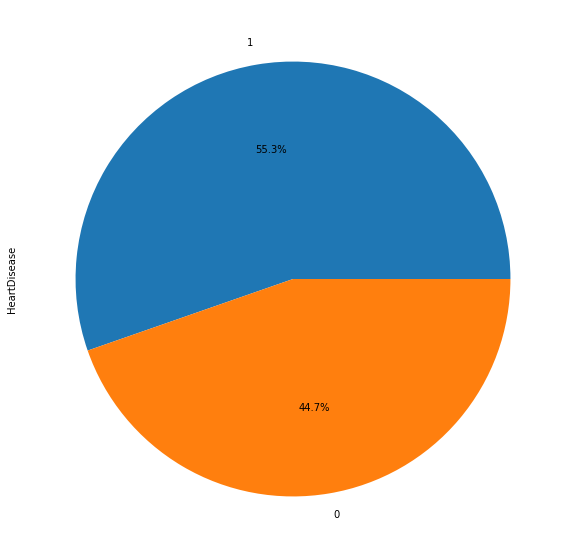

In [22]:
print(df["HeartDisease"].value_counts())
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%',figsize=(10,10));

In [23]:
y = df['HeartDisease']
print(f'Percentage of Heart Disease: % {round(y.value_counts(normalize=True)[1]*100,2)} --> \
({y.value_counts()[1]} cases for Heart Disease)\nPercentage of NOT Heart Disease: % {round(y.value_counts(normalize=True)[0]*100,2)} --> ({y.value_counts()[0]} cases for NOT Heart Disease)')

Percentage of Heart Disease: % 55.34 --> (508 cases for Heart Disease)
Percentage of NOT Heart Disease: % 44.66 --> (410 cases for NOT Heart Disease)


In [24]:
df['HeartDisease'].describe()

count   918.000
mean      0.553
std       0.497
min       0.000
25%       0.000
50%       1.000
75%       1.000
max       1.000
Name: HeartDisease, dtype: float64

In [25]:
df[df['HeartDisease']==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Age,410.000000,50.551220,9.444915,28.000000,43.000000,51.000000,57.000000,76.000000
RestingBP,410.000000,130.180488,16.499585,80.000000,120.000000,130.000000,140.000000,190.000000
Cholesterol,410.000000,227.121951,74.634659,0.000000,197.250000,227.000000,266.750000,564.000000
FastingBS,410.000000,0.107317,0.309894,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,410.000000,148.151220,23.288067,69.000000,134.000000,150.000000,165.000000,202.000000
Oldpeak,410.000000,0.408049,0.699709,-1.100000,0.000000,0.000000,0.600000,4.200000
HeartDisease,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
df[df['HeartDisease']==1].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Age,508.000000,55.899606,8.727056,31.000000,51.000000,57.000000,62.000000,77.000000
RestingBP,508.000000,134.185039,19.828685,0.000000,120.000000,132.000000,145.000000,200.000000
Cholesterol,508.000000,175.940945,126.391398,0.000000,0.000000,217.000000,267.000000,603.000000
FastingBS,508.000000,0.334646,0.472332,0.000000,0.000000,0.000000,1.000000,1.000000
MaxHR,508.000000,127.655512,23.386923,60.000000,112.000000,126.000000,144.250000,195.000000
Oldpeak,508.000000,1.274213,1.151872,-2.600000,0.000000,1.200000,2.000000,6.200000
HeartDisease,508.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
print( f"Skewness: {df['HeartDisease'].skew()}")

Skewness: -0.21508633825088655


In [28]:
print( f"Kurtosis: {df['HeartDisease'].kurtosis()}")

Kurtosis: -1.9580084425329685


In [29]:
df['HeartDisease'].iplot(kind='hist')

**Spliting Dataset into numeric & categoric features**

In [30]:
numerical= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


### Numerical Columns

In [31]:
df[numerical].head().T

,0,1,2,3,4
Age,40.000,49.000,37.000,48.000,54.000
RestingBP,140.000,160.000,130.000,138.000,150.000
Cholesterol,289.000,180.000,283.000,214.000,195.000
FastingBS,0.000,0.000,0.000,0.000,0.000
MaxHR,172.000,156.000,98.000,108.000,122.000
Oldpeak,0.000,1.000,0.000,1.500,0.000


In [32]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.000,53.511,9.433,28.000,47.000,54.000,60.000,77.000
RestingBP,918.000,132.397,18.514,0.000,120.000,130.000,140.000,200.000
Cholesterol,918.000,198.800,109.384,0.000,173.250,223.000,267.000,603.000
FastingBS,918.000,0.233,0.423,0.000,0.000,0.000,0.000,1.000
MaxHR,918.000,136.809,25.460,60.000,120.000,138.000,156.000,202.000
Oldpeak,918.000,0.887,1.067,-2.600,0.000,0.600,1.500,6.200


In [33]:
df[numerical].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Age,918.000000,53.510893,9.432617,28.000000,47.000000,54.000000,60.000000,77.000000
RestingBP,918.000000,132.396514,18.514154,0.000000,120.000000,130.000000,140.000000,200.000000
Cholesterol,918.000000,198.799564,109.384145,0.000000,173.250000,223.000000,267.000000,603.000000
FastingBS,918.000000,0.233115,0.423046,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,918.000000,136.809368,25.460334,60.000000,120.000000,138.000000,156.000000,202.000000
Oldpeak,918.000000,0.887364,1.066570,-2.600000,0.000000,0.600000,1.500000,6.200000


In [34]:
df[numerical].iplot(kind='hist');

In [35]:
df[numerical].iplot(kind='histogram',subplots=True,bins=50)

In [36]:
for i in numerical:
    df[i].iplot(kind="box", title=i, boxpoints="all", color='lightseagreen')

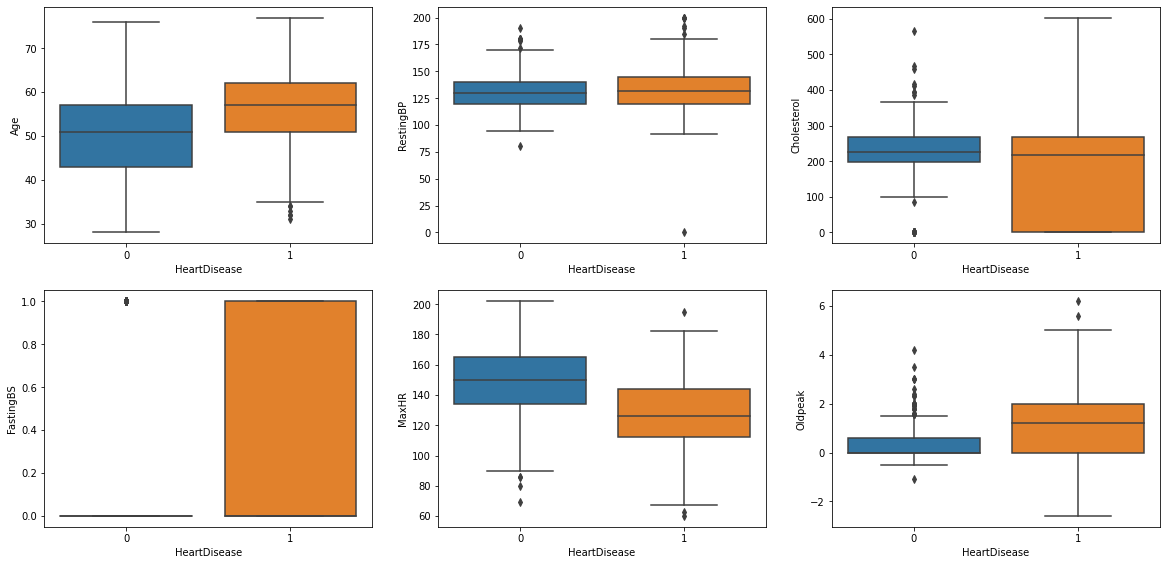

In [37]:
index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "HeartDisease":
        index += 1
        plt.subplot(4,3,index)
        sns.boxplot(x='HeartDisease',y=feature,data=df)

In [38]:
fig = px.scatter_3d(df, 
                    x='RestingBP',
                    y='Age',
                    z='Sex',
                    color='HeartDisease')
fig.show();

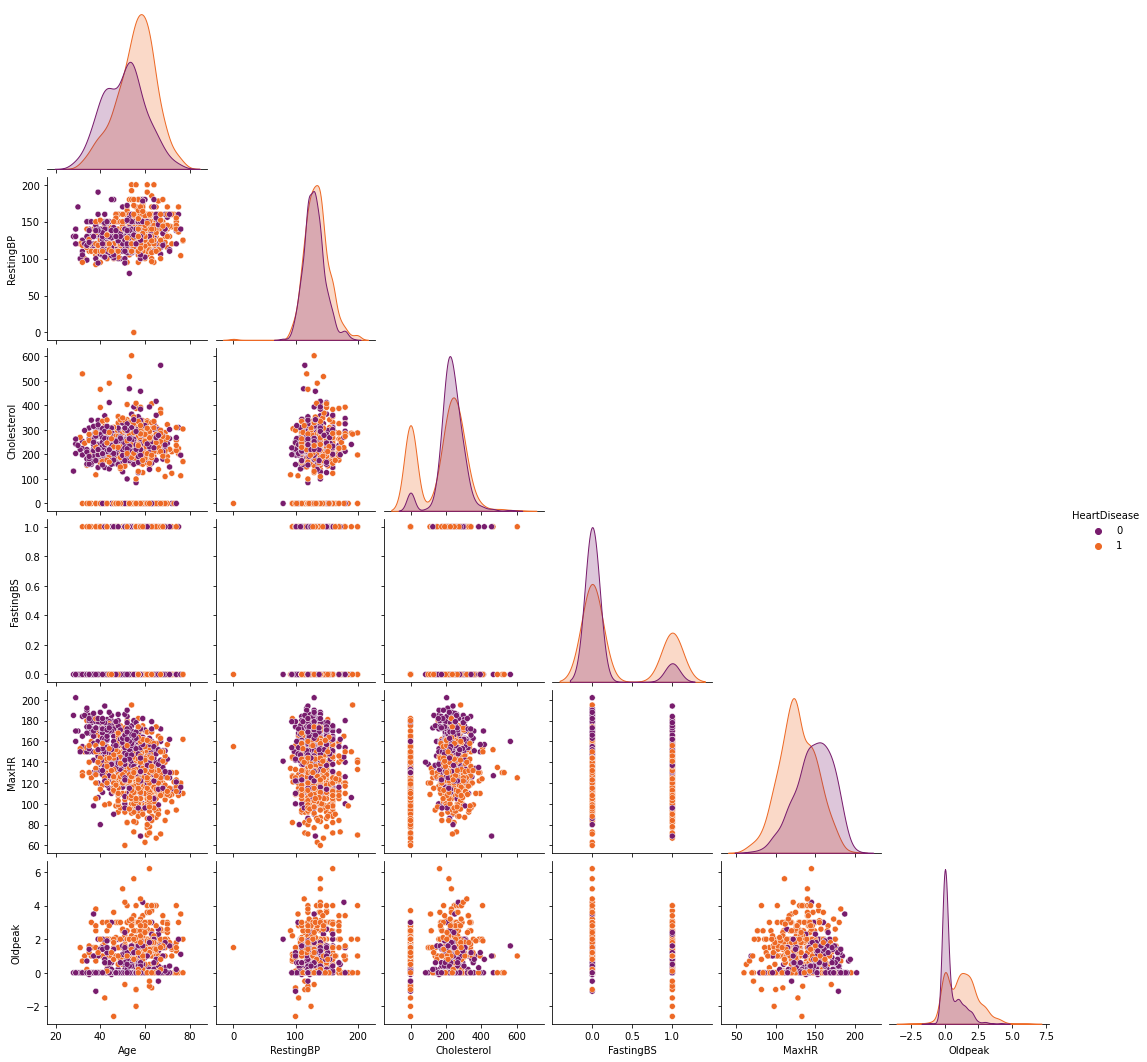

In [39]:
sns.pairplot(df, hue="HeartDisease", palette="inferno", corner=True);

**The Examination of Skewness & Kurtosis**

In [40]:
skew_vals = df.skew().sort_values(ascending=False)
skew_vals

FastingBS       1.264
Oldpeak         1.023
RestingBP       0.180
MaxHR          -0.144
Age            -0.196
HeartDisease   -0.215
Cholesterol    -0.610
dtype: float64

In [41]:
skew_limit = 0.5 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
skew_vals = df.skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols 

FastingBS      1.264
Oldpeak        1.023
Cholesterol   -0.610
dtype: float64

In [42]:
#Interpreting Skewness 

for skew in skew_vals:
    if -0.5 < skew < 0.5:
        print ("A skewness value of", '\033[1m', Fore.GREEN, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.GREEN, "symmetric", '\033[0m')
    elif  -0.5 < skew < -1.0 or 0.5 < skew < 1.0:
        print ("A skewness value of", '\033[1m', Fore.YELLOW, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.YELLOW, "moderately skewed", '\033[0m')
    else:
        print ("A skewness value of", '\033[1m', Fore.RED, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.RED, "highly skewed", '\033[0m')

A skewness value of   -0.19593302867569365  means that the distribution is approx.   symmetric 
A skewness value of   0.1798393100516288  means that the distribution is approx.   symmetric 
A skewness value of   -0.6100864307268192  means that the distribution is approx.   highly skewed 
A skewness value of   1.2644841750727027  means that the distribution is approx.   highly skewed 
A skewness value of   -0.14435941846180994  means that the distribution is approx.   symmetric 
A skewness value of   1.0228720218107528  means that the distribution is approx.   highly skewed 
A skewness value of   -0.21508633825088655  means that the distribution is approx.   symmetric 


Kurtosis are of three types:

Mesokurtic: When the tails of the distibution is similar to the normal distribution then it is mesokurtic. The kutosis for normal distibution is 3.

Leptokurtic: If the kurtosis is greater than 3 then it is leptokurtic. In this case, the tails will be heaviour than the normal distribution which means lots of outliers are present in the data. It can be recognized as thin bell shaped distribution with peak higher than normal distribution.

Platykurtic: Kurtosis will be less than 3 which implies thinner tail or lack of outliers than normal distribution.In case of platykurtic, bell shaped distribution will be broader and peak will be lower than the mesokurtic.
Hair et al. (2010) and Bryne (2010) argued that data is considered to be normal if Skewness is between ‐2 to +2 and Kurtosis is between ‐7 to +7.

Multi-normality data tests are performed using leveling asymmetry tests (skewness < 3), (Kurtosis between -2 and 2) and Mardia criterion (< 3). Source Chemingui, H., & Ben lallouna, H. (2013).

Skewness and kurtosis index were used to identify the normality of the data. The result suggested the deviation of data from normality was not severe as the value of skewness and kurtosis index were below 3 and 10 respectively (Kline, 2011). Source Yadav, R., & Pathak, G. S. (2016).

In [43]:
kurtosis_vals = df.kurtosis().sort_values(ascending=False)
kurtosis_vals

RestingBP       3.271
Oldpeak         1.203
Cholesterol     0.118
Age            -0.386
FastingBS      -0.402
MaxHR          -0.448
HeartDisease   -1.958
dtype: float64

In [44]:
#Calculating Kurtosis 

kurtosis_limit = 7 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
kurtosis_vals = df.kurtosis()
kurtosis_cols = kurtosis_vals[abs(kurtosis_vals) > kurtosis_limit].sort_values(ascending=False)
kurtosis_cols

Series([], dtype: float64)

For preventing data leakage, we need to handle with kurtosis and skewness issue after splitting our data into train and test sets.

**For this purpose, we will use pipeline() since The pipeline can be used as any other estimator and avoids leaking the test set into the train set**

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

https://machinelearningmastery.com/power-transforms-with-scikit-learn/

Before deeping into the analysis it would be benefical to examine the correlation among variables using heatmap.

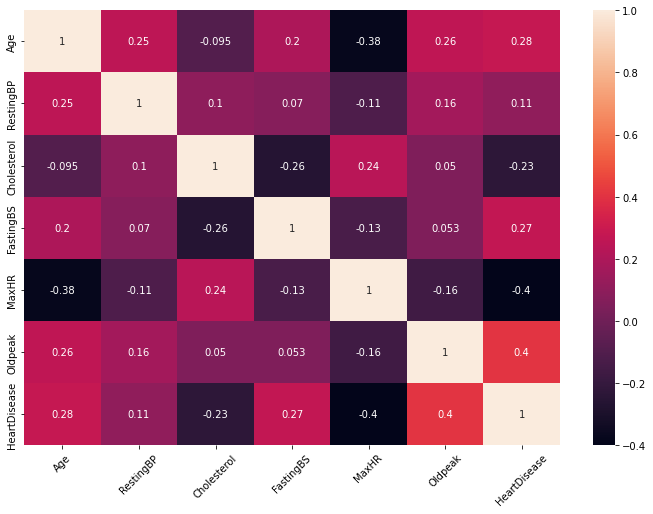

In [45]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)
plt.xticks(rotation=45);

In [46]:
df_temp = df.corr()

count = "Done"
feature =[]
collinear=[]
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i]> .9 and df_temp[col][i] < 1) or (df_temp[col][i]< -.9 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                print(Fore.RED + f"\033[1mmulticolinearity alert in between\033[0m {col} - {i}")
        else:
            print(f"For {col} and {i}, there is NO multicollinearity problem") 

print("\033[1mThe number of strong corelated features:\033[0m", count) 

For Age and Age, there is NO multicollinearity problem
For Age and RestingBP, there is NO multicollinearity problem
For Age and Cholesterol, there is NO multicollinearity problem
For Age and FastingBS, there is NO multicollinearity problem
For Age and MaxHR, there is NO multicollinearity problem
For Age and Oldpeak, there is NO multicollinearity problem
For Age and HeartDisease, there is NO multicollinearity problem
For RestingBP and Age, there is NO multicollinearity problem
For RestingBP and RestingBP, there is NO multicollinearity problem
For RestingBP and Cholesterol, there is NO multicollinearity problem
For RestingBP and FastingBS, there is NO multicollinearity problem
For RestingBP and MaxHR, there is NO multicollinearity problem
For RestingBP and Oldpeak, there is NO multicollinearity problem
For RestingBP and HeartDisease, there is NO multicollinearity problem
For Cholesterol and Age, there is NO multicollinearity problem
For Cholesterol and RestingBP, there is NO multicolline

### Categorical Columns

In [47]:
df[categorical].head().T

,0,1,2,3,4
Sex,M,F,M,F,M
ChestPainType,ATA,NAP,ATA,ASY,NAP
RestingECG,Normal,Normal,ST,Normal,Normal
ExerciseAngina,N,N,N,Y,N
ST_Slope,Up,Flat,Up,Flat,Up


In [48]:
df[categorical].describe()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [49]:
for i in categorical:
    df[i].iplot(kind="box", title=i, boxpoints="all", color='lightseagreen')

In [50]:
df[categorical].iplot(kind='hist');

In [51]:
df[categorical].iplot(kind='histogram',subplots=True,bins=50)

**Sex and HeartDisease**

In [52]:
df["Sex"].value_counts()

M    725
F    193
Name: Sex, dtype: int64

In [53]:
df['Sex'].iplot(kind='hist', )

<AxesSubplot:xlabel='Sex', ylabel='Age'>

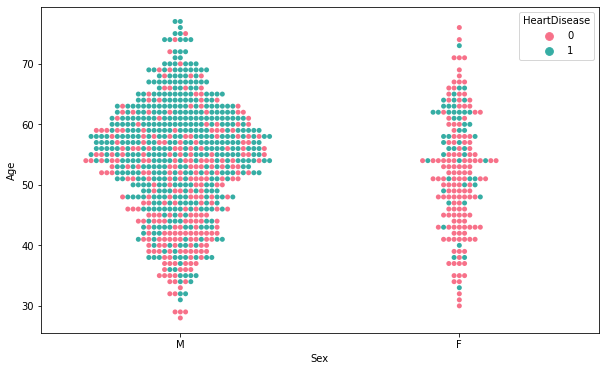

In [54]:
sns.swarmplot(y="Age", x="Sex", hue="HeartDisease", data=df, palette="husl");

**ChestPainType and HeartDisease**

In [55]:
df["ChestPainType"].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [56]:
df['ChestPainType'].iplot(kind='hist', )

<AxesSubplot:xlabel='ChestPainType', ylabel='Age'>

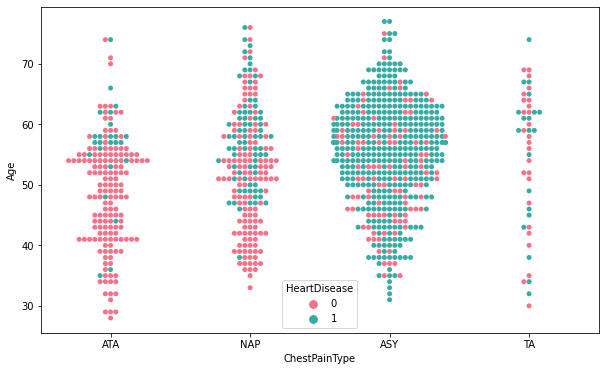

In [57]:
sns.swarmplot(y="Age", x="ChestPainType", hue="HeartDisease", data=df, palette="husl");

**RestingECG and HeartDisease**

In [58]:
df["RestingECG"].value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [59]:
df['RestingECG'].iplot(kind='hist')

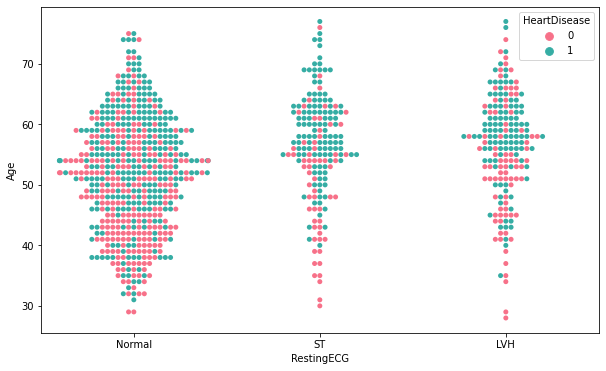

In [60]:
sns.swarmplot(y="Age", x="RestingECG", hue="HeartDisease", data=df, palette="husl");

**ExerciseAngina and HeartDisease**

In [61]:
df["ExerciseAngina"].value_counts()

N    547
Y    371
Name: ExerciseAngina, dtype: int64

In [62]:
df['ExerciseAngina'].iplot(kind='hist')

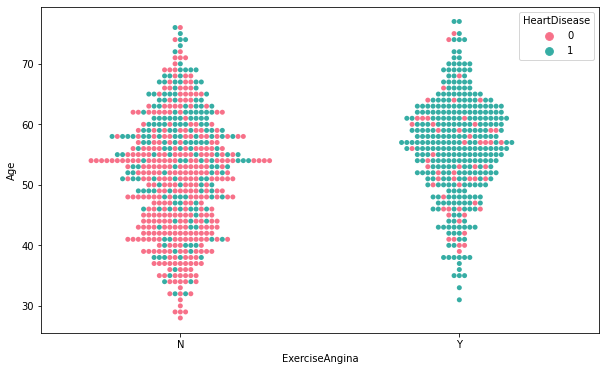

In [63]:
sns.swarmplot(y="Age", x="ExerciseAngina", hue="HeartDisease", data=df, palette="husl");

**ST_Slope and HeartDisease**

In [64]:
df["ST_Slope"].value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

In [65]:
df['ST_Slope'].iplot(kind='hist')

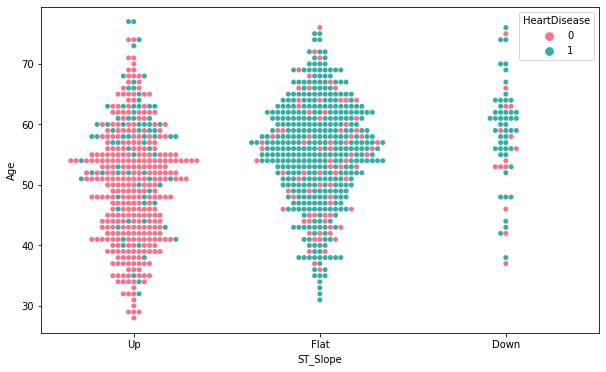

In [66]:
sns.swarmplot(y="Age", x="ST_Slope", hue="HeartDisease", data=df, palette="husl");

# Dummy Operations

In [67]:
df.shape

(918, 12)

In [68]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000,Up,0


In [69]:
df[categorical].value_counts()

Sex  ChestPainType  RestingECG  ExerciseAngina  ST_Slope
M    ASY            Normal      Y               Flat        109
     ATA            Normal      N               Up           64
     ASY            Normal      N               Flat         55
                    ST          Y               Flat         49
     NAP            Normal      N               Up           46
                                                           ... 
F    NAP            ST          Y               Flat          1
     TA             LVH         N               Up            1
                    Normal      N               Down          1
M    ATA            LVH         Y               Flat          1
     TA             ST          Y               Flat          1
Length: 95, dtype: int64

In [70]:
df = pd.get_dummies(df, drop_first=True)

In [71]:
df.shape

(918, 16)

In [72]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.000,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.000,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.000,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.500,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.000,0,1,0,1,0,1,0,0,0,1


# Data Preprocessing

In [73]:
X = df.drop(["HeartDisease"], axis=1)
y = df["HeartDisease"]

### Train / Test and Split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify = y, random_state = 101)

### Feature Scalling

In [75]:
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [76]:
X_train_scaled = scaler.fit_transform(X_train)

In [77]:
X_test_scaled = scaler.transform(X_test)

# General Insights Before Going Further

In [135]:
# General Insights

def model_first_insight(X_train, y_train, class_weight):
    # Logistic Regression
    log = LogisticRegression(random_state=101, class_weight=class_weight)
    log.fit(X_train, y_train)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=101, class_weight=class_weight)
    decision_tree.fit(X_train, y_train)
   
    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=10, criterion = 'entropy', random_state=101, class_weight=class_weight)
    random_forest.fit(X_train, y_train)
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train) 
   
    # SVC
    svc = SVC(random_state=101, class_weight=class_weight)
    svc.fit(X_train, y_train) 
    
    # XGB
    xgb = XGBClassifier(random_state=101, class_weight=class_weight)
    xgb.fit(X_train, y_train)
    
    # AdaBoosting
    ab = AdaBoostClassifier(n_estimators=50, random_state=101)
    ab.fit(X_train, y_train)
    
    # GB GradientBoosting
    gb = GradientBoostingClassifier(random_state=101)
    gb.fit(X_train, y_train)
    
    # Model Accuracy on Training Data
    print(f"\033[1m1) Logistic Regression Training Accuracy:\033[0m {log.score(X_train, y_train)}")
    print(f"\033[1m2) SVC Training Accuracy:\033[0m {svc.score(X_train, y_train)}")    
    print(f"\033[1m3) Decision Tree Training Accuracy:\033[0m {decision_tree.score(X_train, y_train)}")
    print(f"\033[1m4) Random Forest Training Accuracy:\033[0m {random_forest.score(X_train, y_train)}")
    print(f"\033[1m5) KNN Training Accuracy:\033[0m {knn.score(X_train, y_train)}")
    print(f"\033[1m6) GradiendBoosting Training Accuracy:\033[0m {gb.score(X_train, y_train)}")
    print(f"\033[1m7) AdaBoosting Training Accuracy:\033[0m {ab.score(X_train, y_train)}")
    print(f"\033[1m8) XGBoosting Training Accuracy:\033[0m {xgb.score(X_train, y_train)}")
    
    return log, svc, decision_tree, random_forest, knn, gb, ab, xgb

In [136]:
def models(X_train, y_train, class_weight):
    
    # Logistic Regression
    log = LogisticRegression(random_state=101, class_weight=class_weight)
    log.fit(X_train, y_train)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=101, class_weight=class_weight)
    decision_tree.fit(X_train, y_train)
    
    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=10, criterion = 'entropy', random_state=101, class_weight=class_weight)
    random_forest.fit(X_train, y_train)
    # KNN
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train) 
   
    # SVC
    svc = SVC(random_state=101, class_weight=class_weight)
    svc.fit(X_train, y_train) 
    
    # XGB
    xgb = XGBClassifier(random_state=101, class_weight=class_weight)
    xgb.fit(X_train, y_train)
    
    # AdaBoosting
    ab = AdaBoostClassifier(n_estimators=50, random_state=101)
    ab.fit(X_train, y_train)
    
    # GB GradientBoosting
    gb = GradientBoostingClassifier(random_state=101)
    gb.fit(X_train, y_train)
    
    # Model Accuracy on Training Data
    print(f"\033[1m1) Logistic Regression Training Accuracy:\033[0m {log}")
    print(f"\033[1m2) SVC Training Accuracy:\033[0m {svc}")    
    print(f"\033[1m3) Decision Tree Training Accuracy:\033[0m {decision_tree}")
    print(f"\033[1m4) Random Forest Training Accuracy:\033[0m {random_forest}")
    print(f"\033[1m5) KNN Training Accuracy:\033[0m {knn}")
    print(f"\033[1m6) GradiendBoosting Training Accuracy:\033[0m {gb}")
    print(f"\033[1m7) AdaBoosting Training Accuracy:\033[0m {ab}")
    print(f"\033[1m8) XGBoosting Training Accuracy:\033[0m {xgb}")
  
    return log.score(X_train, y_train), svc.score(X_train, y_train),decision_tree.score(X_train, y_train),random_forest.score(X_train, y_train),knn.score(X_train, y_train),gb.score(X_train, y_train),ab.score(X_train, y_train),xgb.score(X_train, y_train)

In [137]:
def models_accuracy(X_Set, y_Set):    
    Scores = pd.DataFrame(columns = ["LR_Acc", "SVC_Acc", "DT_Acc", "RF_Acc", "KNN_Acc", "GB_Acc", "AB_Acc", "XGB_Acc"])

    print("\033[1mBASIC ACCURACY\033[0m")
    Basic = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, None)
    Scores.loc[0] = Basic

    print("\n\033[1mSCALED ACCURACY WITHOUT BALANCED\033[0m")    
    Scaled = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, None)
    Scores.loc[1] = Scaled

    
    print("\n\033[1mBASIC ACCURACY WITH BALANCED\033[0m")
    Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, "balanced")
    Scores.loc[2] = Balanced

    print("\n\033[1mSCALED ACCURACY WITH BALANCED\033[0m")    
    Scaled_Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, "balanced")
    Scores.loc[3] = Scaled_Balanced

    Scores.set_axis(['Basic', 'Scaled', 'Balanced', 'Scaled_Balanced'], axis='index', inplace=True)
    #Scores.style.background_gradient(cmap='RdPu')

    return Scores.style.applymap(lambda x: "background-color: pink" if x<0.6 or x == 1 else "background-color: lightgreen")\
                       .applymap(lambda x: 'opacity: 40%;' if (x < 0.8) else None)\
                       .applymap(lambda x: 'color: red' if x == 1 or x <=0.8 else 'color: darkblue')

# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

In [138]:
models_accuracy(X_train, y_train)

BASIC ACCURACY
[10:57:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(random_state=101)
2) SVC Training Accuracy: SVC(random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(criterion='entropy', random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jo

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(random_state=101)
2) SVC Training Accuracy: SVC(random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(criterion='entropy', random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jo

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(class_weight='balanced', random_state=101)
2) SVC Training Accuracy: SVC(class_weight='balanced', random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(class_weight='balanced', random_state=101)
2) SVC Training Accuracy: SVC(class_weight='balanced', random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


In [82]:
Scores = pd.DataFrame(columns = ["LR_Acc", "SVC_Acc", "DT_Acc", "RF_Acc", "KNN_Acc", "GB_Acc", "AB_Acc", "XGB_Acc"])

print("\033[1mBASIC ACCURACY\033[0m")
Basic = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, None)
Scores.loc[0] = Basic

print("\n\033[1mSCALED ACCURACY WITHOUT BALANCED\033[0m")    
Scaled = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, None)
Scores.loc[1] = Scaled

print("\n\033[1mBASIC ACCURACY WITH BALANCED\033[0m")
Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, "balanced")
Scores.loc[2] = Balanced

print("\n\033[1mSCALED ACCURACY WITH BALANCED\033[0m")    
Scaled_Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, "balanced")
Scores.loc[3] = Scaled_Balanced

Scores.set_axis(['Basic', 'Scaled', 'Balanced', 'Scaled_Balanced'], axis='index', inplace=True)

BASIC ACCURACY
[09:37:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(random_state=101)
2) SVC Training Accuracy: SVC(random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(criterion='entropy', random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jo

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(random_state=101)
2) SVC Training Accuracy: SVC(random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(criterion='entropy', random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jo

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(class_weight='balanced', random_state=101)
2) SVC Training Accuracy: SVC(class_weight='balanced', random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(class_weight='balanced', random_state=101)
2) SVC Training Accuracy: SVC(class_weight='balanced', random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.

In [83]:
accuracy_scores = Scores.style.applymap(lambda x: "background-color: pink" if x<0.6 or x == 1 else "background-color: lightgreen")\
                              .applymap(lambda x: 'opacity: 40%;' if (x < 0.8) else None)\
                              .applymap(lambda x: 'color: red' if x == 1 or x <=0.8 else 'color: darkblue')

accuracy_scores

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


In [84]:
# def _color_red_or_green(val):
#     color = 'red' if val < 0.6 or val == 1 else 'green'
#     return 'color: %s' % color

In [85]:
# Scores.style.applymap(_color_red_or_green)

In [86]:
# Scores.style.applymap(lambda x: "background-color: red" if x<0.6 or x == 1 else "background-color: lightblue")

In [87]:
# cm = sns.light_palette("green", as_cmap=True)
# Scores.style.background_gradient(cmap=cm)

In [88]:
# cm = sns.light_palette("red", as_cmap=True)
# Scores.style.text_gradient(cmap=cm)

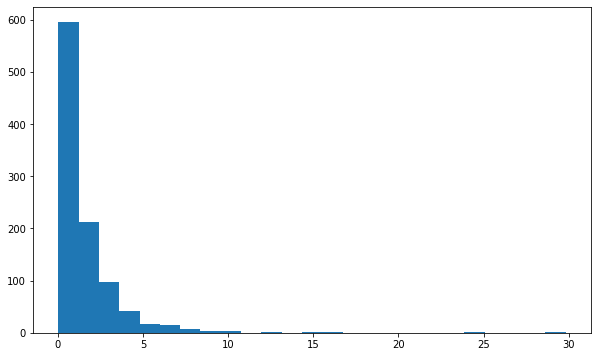

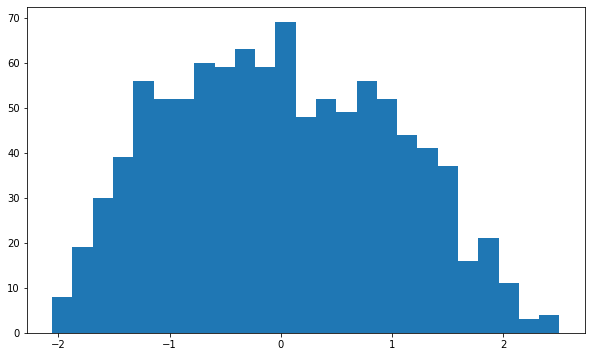

In [89]:
# demonstration of the power transform on data with a skew
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot
# generate gaussian data sample
data = randn(1000)
# add a skew to the data distribution
data = exp(data)
# histogram of the raw data with a skew
pyplot.hist(data, bins=25)
pyplot.show()
# reshape data to have rows and columns
data = data.reshape((len(data),1))
# power transform the raw data
power = PowerTransformer(method='yeo-johnson', standardize=True)
data_trans = power.fit_transform(data)
# histogram of the transformed data
pyplot.hist(data_trans, bins=25)
pyplot.show()

In [90]:
# visualize a box-cox transform of the sonar dataset
# from pandas import read_csv
# from pandas import DataFrame
# from pandas.plotting import scatter_matrix
# from sklearn.preprocessing import PowerTransformer
# from matplotlib import pyplot
# # Load dataset
# url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv"
# dataset = read_csv(url, header=None)
# # retrieve just the numeric input values
# data = dataset.values[:, :-1]
# # perform a box-cox transform of the dataset
# pt = PowerTransformer(method='box-cox')
# data = pt.fit_transform(data)
# # convert the array back to a dataframe
# dataset = DataFrame(data)
# # histograms of the variables
# dataset.hist()
# pyplot.show()

ValueError: The Box-Cox transformation can only be applied to strictly positive data

In [ ]:
# evaluate knn on the box-cox sonar dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv"
dataset = read_csv(url, header=None)
data = dataset.values
# separate into input and output columns
X, y = data[:, :-1], data[:, -1]
# ensure inputs are floats and output is an integer label
X = X.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))
# define the pipeline
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[('s', scaler),('p', power), ('m', model)])
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

## Handling with Skewness with PowerTransform & Checking Confusion Matrix & Model Accuracy

In [91]:
accuracy_scores

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


In [123]:
operations = [("scaler", MinMaxScaler()), ("power", PowerTransformer()), ("log", LogisticRegression())]

In [124]:
# Defining the pipeline for LogisticClassifier

pipe_log_model = Pipeline(steps=operations)

In [108]:
# Defining the pipeline for LogisticClassifier

# scaler = MinMaxScaler()
# power = PowerTransformer(method='yeo-johnson')
# pipe_model = LogisticRegression(random_state=101,)
# pipe_log_model = Pipeline(steps=[('s', scaler),('p', power), ('m', pipe_model)])

In [126]:
pipe_log_model.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('power', PowerTransformer()),
  ('log', LogisticRegression())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'power': PowerTransformer(),
 'log': LogisticRegression(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'power__copy': True,
 'power__method': 'yeo-johnson',
 'power__standardize': True,
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': None,
 'log__max_iter': 100,
 'log__multi_class': 'auto',
 'log__n_jobs': None,
 'log__penalty': 'l2',
 'log__random_state': None,
 'log__solver': 'lbfgs',
 'log__tol': 0.0001,
 'log__verbose': 0,
 'log__warm_start': False}

In [127]:
pipe_log_model.fit(X_train, y_train)
y_pred = pipe_model.predict(X_test)
y_train_pred = pipe_model.predict(X_train)

In [128]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[58  4]
 [56 20]]
              precision    recall  f1-score   support

           0       0.51      0.94      0.66        62
           1       0.83      0.26      0.40        76

    accuracy                           0.57       138
   macro avg       0.67      0.60      0.53       138
weighted avg       0.69      0.57      0.52       138



**SPECIAL NOTE: When we examine the results after handling with skewness, it's clear to assume that handling with skewness could NOT make any contribution to our model when comparing the results obtained by LogisticClassifier without using PowerTransform. So for the next steps in this study we will continue not handling with skewness assuming that it's useless for the results**  

In [129]:
pipe_scores = cross_validate(pipe_log_model, X_train, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = 10)
df_pipe_scores = pd.DataFrame(pipe_scores, index = range(1, 11))

df_pipe_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.068,0.008,0.795,0.787,0.860,0.822
2,0.066,0.007,0.821,0.822,0.860,0.841
3,0.059,0.007,0.885,0.886,0.907,0.897
4,0.066,0.008,0.833,0.875,0.814,0.843
5,0.062,0.008,0.897,0.889,0.930,0.909
6,0.070,0.007,0.821,0.822,0.860,0.841
7,0.063,0.007,0.872,0.851,0.930,0.889
8,0.062,0.008,0.833,0.826,0.884,0.854
9,0.065,0.008,0.833,0.878,0.818,0.847
10,0.061,0.008,0.923,0.913,0.955,0.933


In [130]:
df_pipe_scores.mean()[2:]

test_accuracy    0.851
test_precision   0.855
test_recall      0.882
test_f1          0.868
dtype: float64

In [131]:
# evaluate the pipeline

from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, random_state=101)
n_scores = cross_val_score(pipe_log_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print(f'Accuracy: Results Mean : %{round(n_scores.mean()*100,3)}, Results Standard Deviation : {round(n_scores.std()*100,3)}')

Accuracy: Results Mean : %85.75, Results Standard Deviation : 3.228


In [132]:
print('Accuracy: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

Accuracy: 0.858 (0.032)


# LOGISTIC REGRESSION

## Modelling & Model Performance

**First take a close look at the models' accuracy scores for comparing the results given by Scaled, Not Scaled, Balanced and Not Balanced models**

In [227]:
accuracy_scores

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


[[51 11]
 [ 6 70]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.82      0.86        62
           1       0.86      0.92      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.87       138
weighted avg       0.88      0.88      0.88       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.862,0.877
Precision,0.867,0.864
Recall,0.887,0.921
f1,0.876,0.892


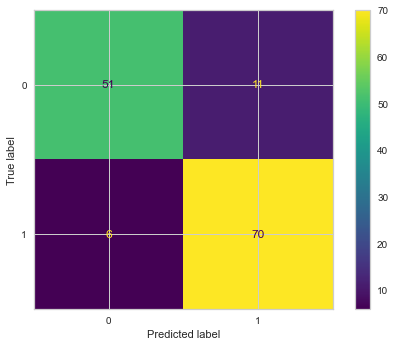

In [228]:
LR_model = LogisticRegression() # Since Basic accuracy outcome gives the best model accuracy results, we will implement it 
LR_model.fit(X_train_scaled, y_train)
y_pred = LR_model.predict(X_test_scaled)
y_train_pred = LR_model.predict(X_train_scaled)

log_f1 = f1_score(y_test, y_pred)
log_acc = accuracy_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
log_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(LR_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [164]:
log_pred_proba = log_model.predict_proba(X_test_scaled)

In [165]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data["pred"] = log_pred
test_data["pred_proba"] = log_pred_proba[:,1]
test_data.sample(10)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease,pred,pred_proba
766,50,120,219,0,158,1.600,0,0,1,0,1,0,0,1,0,0,0,0.258
589,74,140,237,1,94,0.000,1,0,1,0,1,0,0,1,0,1,1,0.808
610,54,127,333,1,154,0.000,0,0,0,0,0,1,0,1,0,1,1,0.700
855,68,180,274,1,150,1.600,1,0,1,0,0,0,1,1,0,1,1,0.929
624,63,150,407,0,154,4.000,0,0,0,0,0,0,0,1,0,1,1,0.686
45,59,130,318,0,120,1.000,1,0,1,0,1,0,1,1,0,0,1,0.731
213,56,130,219,0,164,0.000,0,0,1,0,0,1,0,0,1,0,0,0.026
75,46,150,163,0,116,0.000,1,0,1,0,1,0,0,0,1,0,0,0.098
602,61,120,337,0,98,0.000,1,0,1,0,1,0,1,1,0,1,1,0.694
590,63,136,165,0,133,0.200,1,1,0,0,0,1,0,0,1,0,0,0.108


In [145]:
# cm = ConfusionMatrix(log_model)
# cm.fit(X_train_scaled, y_train)
# cm.score(X_test_scaled, y_test)
# cm.show();

NameError: name 'ConfusionMatrix' is not defined

## Cross Validate

In [187]:
log_xvalid_model = LogisticRegression()

log_xvalid_model_scores = cross_validate(log_xvalid_model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall',
                                                                          'f1'], cv = 10)
log_xvalid_model_scores = pd.DataFrame(log_xvalid_model_scores, index = range(1, 11))

log_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.019,0.004,0.808,0.792,0.884,0.835
2,0.018,0.005,0.821,0.822,0.860,0.841
3,0.026,0.005,0.872,0.884,0.884,0.884
4,0.021,0.006,0.833,0.875,0.814,0.843
5,0.020,0.004,0.910,0.891,0.953,0.921
6,0.016,0.004,0.833,0.841,0.860,0.851
7,0.019,0.005,0.872,0.851,0.930,0.889
8,0.020,0.004,0.846,0.830,0.907,0.867
9,0.019,0.005,0.833,0.897,0.795,0.843
10,0.019,0.004,0.936,0.915,0.977,0.945


In [188]:
log1_xvalid_model_scores.mean()[2:]

test_accuracy    0.854
test_precision   0.871
test_recall      0.866
test_f1          0.867
dtype: float64

## Modelling Logistic Regression (LR) with Best Parameters Using GridSeachCV

In [189]:
penalty = ["l1", "l2", "elasticnet"]
l1_ratio = np.linspace(0, 1, 20)
C = np.logspace(0, 10, 20)

param_grid = {"penalty" : penalty,
             "l1_ratio" : l1_ratio,
             "C" : C}

In [190]:
LR_grid_model = LogisticRegression(solver='saga', max_iter=5000, class_weight = "balanced")

LR_grid_model = GridSearchCV(LR_grid_model, param_grid = param_grid)

In [191]:
LR_grid_model.fit(X_train_scaled, y_train)

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=5000, solver='saga'),
             param_grid={'C': array([1.00000000e+00, 3.35981829e+00, 1.12883789e+01, 3.79269019e+01,
       1.27427499e+02, 4.28133240e+02, 1.43844989e+03, 4.83293024e+03,
       1.62377674e+04, 5.45559478e+04, 1.83298071e+05, 6.15848211e+05,
       2.06913808e+06, 6.95192796e+06, 2.33572147e+07, 7.84759970e+07,
       2.63665090e+08, 8.85866790e+08, 2.97635144e+09, 1.00000000e+10]),
                         'l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']})

Let's look at the best parameters & estimator found by GridSearchCV.

In [192]:
print(colored('\033[1mBest Parameters of GridSearchCV for LR Model:\033[0m', 'blue'), colored(LR_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for LR Model:\033[0m', 'blue'), colored(LR_grid_model.best_estimator_, 'cyan'))

Best Parameters of GridSearchCV for LR Model: {'C': 1.0, 'l1_ratio': 0.47368421052631576, 'penalty': 'elasticnet'}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for LR Model: LogisticRegression(class_weight='balanced', l1_ratio=0.47368421052631576,
                   max_iter=5000, penalty='elasticnet', solver='saga')


[[53  9]
 [ 8 68]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        62
           1       0.88      0.89      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.88       138
weighted avg       0.88      0.88      0.88       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.868,0.877
Precision,0.885,0.883
Recall,0.875,0.895
f1,0.880,0.889


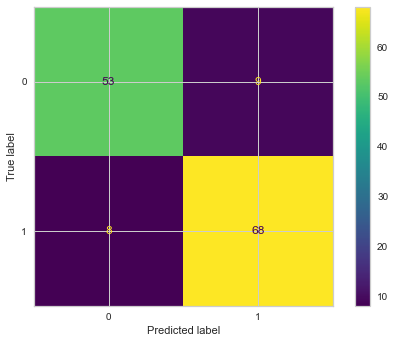

In [229]:
y_pred = LR_grid_model.predict(X_test_scaled)
y_train_pred = LR_grid_model.predict(X_train_scaled)

log_grid_f1 = f1_score(y_test, y_pred)
log_grid_acc = accuracy_score(y_test, y_pred)
log_grid_recall = recall_score(y_test, y_pred)
log_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(LR_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

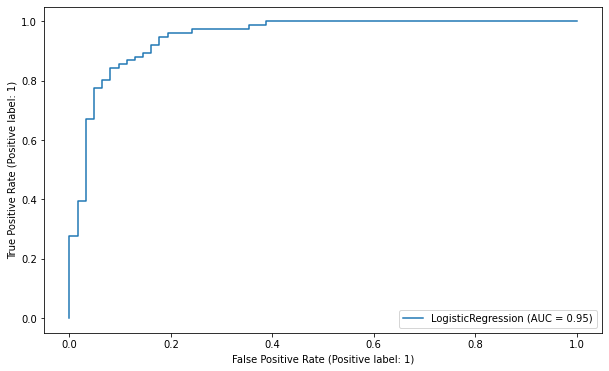

In [194]:
plot_roc_curve(log_model, X_test_scaled, y_test);

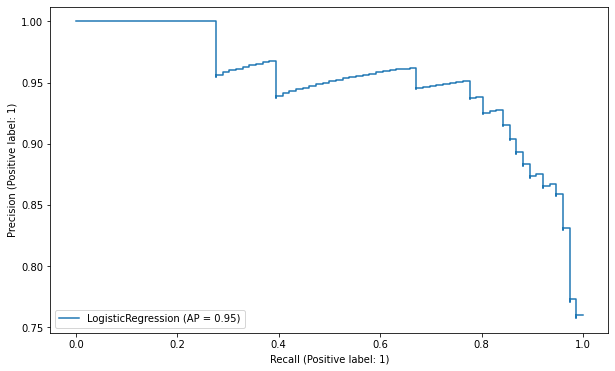

In [195]:
plot_precision_recall_curve(log_model, X_test_scaled, y_test);

### Finding Best Threshold

In [53]:
log_pred_proba = log_model.predict_proba(X_train_scaled)
roc_auc_score(y_train, log_pred_proba[:,1])

0.5215726499994452

In [54]:
fp_rate, tp_rate, thresholds = roc_curve(y_train, log_pred_proba[:,1])

In [55]:
optimal_idx = np.argmax(tp_rate - fp_rate)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.5120265492885842

In [56]:
test_data.head()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability,pred,pred_proba
2947,7.0911316,183.5211070,20461.2527102,7.3332122,333.1194759,356.3690224,20.1790289,67.0199032,4.8866338,0,0,0.4863334
2782,6.6431587,188.9135411,32873.8200217,6.7915094,333.8488419,336.5615010,14.7068103,67.8448489,4.5621977,1,1,0.5135902
1644,7.8460579,224.0588768,23264.1099677,5.9223670,300.4026201,387.9713358,13.4067375,43.0751865,2.4879686,0,0,0.4924927
70,7.1604672,183.0893100,6743.3460655,3.8030364,277.5990986,428.0363444,9.7996247,90.0353737,3.8848910,0,1,0.5071992
2045,6.6153501,179.2406613,26392.8636119,9.3091600,333.9004977,496.3635615,12.7865954,78.2623686,4.4534433,1,1,0.5234929


In [57]:
test_data["pred2"] = test_data["pred_proba"].apply(lambda x : 1 if x >= optimal_threshold else 0)

In [58]:
test_data.head()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability,pred,pred_proba,pred2
2947,7.0911316,183.5211070,20461.2527102,7.3332122,333.1194759,356.3690224,20.1790289,67.0199032,4.8866338,0,0,0.4863334,0
2782,6.6431587,188.9135411,32873.8200217,6.7915094,333.8488419,336.5615010,14.7068103,67.8448489,4.5621977,1,1,0.5135902,1
1644,7.8460579,224.0588768,23264.1099677,5.9223670,300.4026201,387.9713358,13.4067375,43.0751865,2.4879686,0,0,0.4924927,0
70,7.1604672,183.0893100,6743.3460655,3.8030364,277.5990986,428.0363444,9.7996247,90.0353737,3.8848910,0,1,0.5071992,0
2045,6.6153501,179.2406613,26392.8636119,9.3091600,333.9004977,496.3635615,12.7865954,78.2623686,4.4534433,1,1,0.5234929,1


In [59]:
log_pred2 = test_data["pred2"]

In [60]:
print(confusion_matrix(y_test,log_pred2))
print(classification_report(y_test,log_pred2))

[[398 112]
 [207 102]]
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       510
           1       0.48      0.33      0.39       309

    accuracy                           0.61       819
   macro avg       0.57      0.56      0.55       819
weighted avg       0.59      0.61      0.59       819



In [61]:
print(confusion_matrix(y_test,log_pred))
print(classification_report(y_test,log_pred))

[[279 231]
 [150 159]]
              precision    recall  f1-score   support

           0       0.65      0.55      0.59       510
           1       0.41      0.51      0.45       309

    accuracy                           0.53       819
   macro avg       0.53      0.53      0.52       819
weighted avg       0.56      0.53      0.54       819



In [230]:
log_model=LogisticRegression(class_weight = "balanced")
log_model.fit(X_train_scaled, y_train)
y_pred=log_model.predict(X_test_scaled)
y_pred_train = log_model.predict(X_train_scaled)
log_acc = accuracy_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_pred_train, y_test, y_pred)

[[53  9]
 [ 9 67]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        62
           1       0.88      0.88      0.88        76

    accuracy                           0.87       138
   macro avg       0.87      0.87      0.87       138
weighted avg       0.87      0.87      0.87       138



,train_set,test_set
Accuracy,0.868,0.870
Precision,0.887,0.882
Recall,0.873,0.882
f1,0.880,0.882


In [66]:
model = LogisticRegression(class_weight = "balanced")

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
print(df_scores)
print("--------------------")
print(df_scores.mean()[2:])

    fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1
1  0.1908824   0.0156231      0.4959350       0.3738318    0.4123711 0.3921569
2  0.0781155   0.0000000      0.5000000       0.3796296    0.4226804 0.4000000
3  0.0312562   0.0000000      0.4959350       0.3636364    0.3711340 0.3673469
4  0.0312548   0.0156100      0.4918699       0.3906250    0.5154639 0.4444444
5  0.0468655   0.0000000      0.4959350       0.3865546    0.4742268 0.4259259
6  0.0312448   0.0156369      0.5243902       0.4090909    0.4639175 0.4347826
7  0.0312421   0.0156233      0.4796748       0.3675214    0.4432990 0.4018692
8  0.0156140   0.0156410      0.4938776       0.3793103    0.4583333 0.4150943
9  0.0312307   0.0156381      0.4897959       0.3813559    0.4639175 0.4186047
10 0.0156085   0.0156248      0.4979592       0.3968254    0.5154639 0.4484305
--------------------
test_accuracy    0.4965372
test_precision   0.3828381
test_recall      0.4540808
test_f1          0.4148655
dt

#  Implement XGB and Evaluate

## Modelling & Model Performance

**First take a close look at the models' accuracy scores for comparing the results given by Scaled, Not Scaled, Balanced and Not Balanced models**

In [413]:
accuracy_scores

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


[16:12:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[55  7]
 [ 9 67]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        62
           1       0.91      0.88      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138

--------------------------------------------------------


,train_set,test_set
Accuracy,1.000,0.884
Precision,1.000,0.905
Recall,1.000,0.882
f1,1.000,0.893


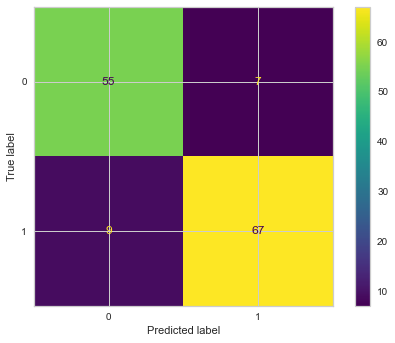

In [231]:
XGB_model = XGBClassifier(random_state=101)
XGB_model.fit(X_train_scaled, y_train)
y_pred = XGB_model.predict(X_test_scaled)
y_train_pred = XGB_model.predict(X_train_scaled)

xgb_f1 = f1_score(y_test, y_pred)
xgb_acc = accuracy_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(XGB_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

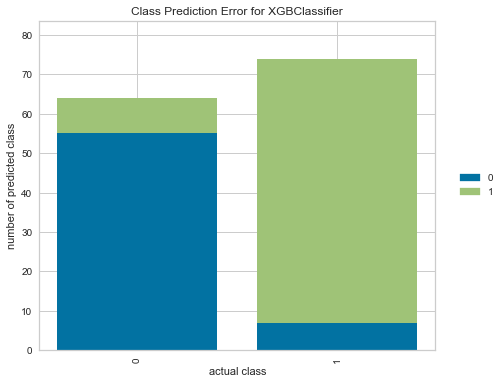

In [203]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(XGB_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

## Cross Validate

In [204]:
xgb_xvalid_model = XGBClassifier(random_state=101)

xgb_xvalid_model_scores = cross_validate(xgb_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
xgb_xvalid_model_scores = pd.DataFrame(xgb_xvalid_model_scores, index = range(1, 11))

xgb_xvalid_model_scores

[13:01:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.141,0.008,0.821,0.837,0.837,0.837
2,0.081,0.008,0.756,0.773,0.791,0.782
3,0.102,0.008,0.897,0.889,0.930,0.909
4,0.082,0.007,0.846,0.860,0.860,0.860
5,0.103,0.008,0.846,0.878,0.837,0.857
6,0.082,0.008,0.885,0.854,0.953,0.901
7,0.083,0.008,0.846,0.816,0.930,0.870
8,0.109,0.008,0.821,0.837,0.837,0.837
9,0.107,0.008,0.808,0.872,0.773,0.819
10,0.110,0.012,0.897,0.891,0.932,0.911


In [205]:
xgb_xvalid_model_scores.mean()

fit_time         0.100
score_time       0.008
test_accuracy    0.842
test_precision   0.851
test_recall      0.868
test_f1          0.858
dtype: float64

## Feature Importance for XGBoosting (XGB) Model

In [207]:
XGB_model.feature_importances_ 

array([0.01034657, 0.00827132, 0.01459766, 0.02276584, 0.01219854,
       0.01343196, 0.020674  , 0.01842576, 0.02250192, 0.01536592,
       0.01140481, 0.01122345, 0.03192241, 0.01766846, 0.7692014 ],
      dtype=float32)

In [208]:
feats = pd.DataFrame(index=X.columns, data=XGB_model.feature_importances_, columns=["Feature Importance"])
XGB_feature_imp = feats.sort_values("Feature Importance", ascending=False)

XGB_feature_imp 

,Feature Importance
ST_Slope_Up,0.769
ExerciseAngina_Y,0.032
FastingBS,0.023
ChestPainType_NAP,0.023
Sex_M,0.021
ChestPainType_ATA,0.018
ST_Slope_Flat,0.018
ChestPainType_TA,0.015
Cholesterol,0.015
Oldpeak,0.013


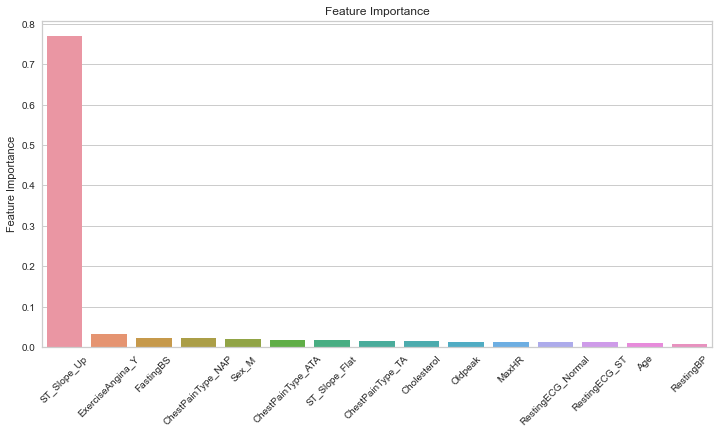

In [209]:
plt.figure(figsize=(12,6))
sns.barplot(y=XGB_feature_imp["Feature Importance"], x=XGB_feature_imp.index)

plt.title("Feature Importance")
plt.xticks(rotation=45)
plt.show()

**The feature that weighs too much on the estimation can SOMETIMES cause overfitting. We are curious about what happens to our model if we drop the feature with contribution. For this reason, the most important feature will be dropped and the scores will be checked again.**

In [217]:
X2 = X.drop(columns = ["ST_Slope_Up"]) 

In [218]:
X2.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y',
       'ST_Slope_Flat'],
      dtype='object')

[16:12:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[55  7]
 [ 9 67]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        62
           1       0.91      0.88      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138

[[55  7]
 [ 9 67]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        62
           1       0.91      0.88      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       

,train_set,test_set
Accuracy,1.000,0.884
Precision,1.000,0.905
Recall,1.000,0.882
f1,1.000,0.893


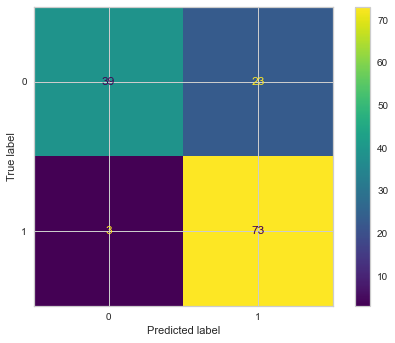

In [232]:
operations = [("scaler", MinMaxScaler()), ("xgb", XGBClassifier(random_state=101))]

XGB_pipe_model = Pipeline(steps=operations)
XGB_pipe_model.get_params()
XGB_pipe_model.fit(X_train, y_train)

y_pred = XGB_pipe_model.predict(X_test)
y_train_pred = XGB_pipe_model.predict(X_train)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

xgb_pipe_f1 = f1_score(y_test, y_pred)
xgb_pipe_acc = accuracy_score(y_test, y_pred)
xgb_pipe_recall = recall_score(y_test, y_pred)
xgb_pipe_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(XGB_pipe_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [221]:
pipe_scores = cross_validate(XGB_pipe_model, X_train, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = 10)
df_pipe_scores = pd.DataFrame(pipe_scores, index = range(1, 11))

df_pipe_scores

[15:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.109,0.009,0.821,0.837,0.837,0.837
2,0.085,0.010,0.756,0.773,0.791,0.782
3,0.106,0.009,0.897,0.889,0.930,0.909
4,0.090,0.010,0.846,0.860,0.860,0.860
5,0.116,0.010,0.846,0.878,0.837,0.857
6,0.101,0.011,0.885,0.854,0.953,0.901
7,0.106,0.010,0.846,0.816,0.930,0.870
8,0.091,0.010,0.821,0.837,0.837,0.837
9,0.108,0.010,0.808,0.872,0.773,0.819
10,0.152,0.010,0.897,0.891,0.932,0.911


In [222]:
df_pipe_scores.mean()[2:]

test_accuracy    0.842
test_precision   0.851
test_recall      0.868
test_f1          0.858
dtype: float64

,train_set,test_set
Accuracy,1.000,0.884
Precision,1.000,0.905
Recall,1.000,0.882
f1,1.000,0.893


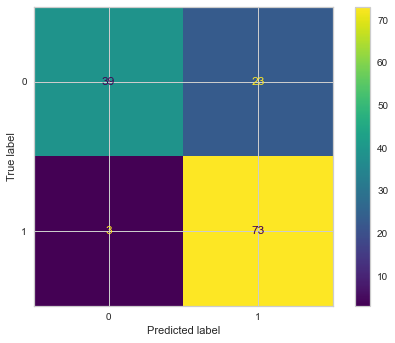

In [233]:
plot_confusion_matrix(XGB_pipe_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

**In general, droping the feature that weighs too much on the estimation did NOT make any sense. While True Positive predictions increased, False Negative ones decreased. This situation should be evaluated in accordiance with what we would assume and DOMAIN KNOWLEDGE** 

In [223]:
# evaluate the pipeline

from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, random_state=101)
n_scores = cross_val_score(XGB_pipe_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print(f'Accuracy: Results Mean : %{round(n_scores.mean()*100,3)}, Results Standard Deviation : {round(n_scores.std()*100,3)}')

Accuracy: Results Mean : %85.949, Results Standard Deviation : 3.57


## Modelling XGBoosting (XGB) with Best Parameters Using GridSearchCV

In [210]:
param_grid = {"n_estimators":[100, 300], 
              "max_depth":[3,5,6], 
              "learning_rate": [0.1, 0.3],
              "subsample":[0.5, 1], 
              "colsample_bytree":[0.5, 1]}

In [211]:
XGB_grid_model = XGBClassifier(random_state=42)
XGB_grid_model = GridSearchCV(XGB_grid_model, param_grid, scoring = "f1", verbose=2, n_jobs = -1)

In [212]:
XGB_grid_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[13:09:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=

In [213]:
print(colored('\033[1mBest Parameters of GridSearchCV for RF Model:\033[0m', 'blue'), colored(XGB_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for RF Model:\033[0m', 'blue'), colored(XGB_grid_model.best_estimator_, 'cyan'))

Best Parameters of GridSearchCV for RF Model: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.5}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for RF Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)


[[54  8]
 [ 6 70]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        62
           1       0.90      0.92      0.91        76

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138

--------------------------------------------------------


ValueError: Found input variables with inconsistent numbers of samples: [780, 138]

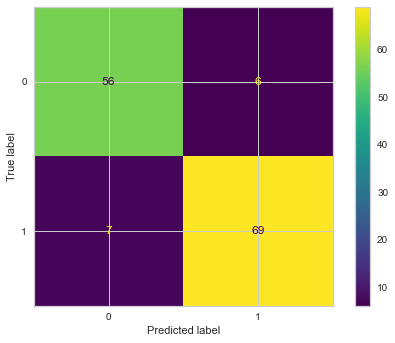

In [433]:
y_train_pred = XGB_grid_model.predict(X_test_scaled)

xgb_grid_f1 = f1_score(y_test, y_pred)
xgb_grid_acc = accuracy_score(y_test, y_pred)
xgb_grid_recall = recall_score(y_test, y_pred)
xgb_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(XGB_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

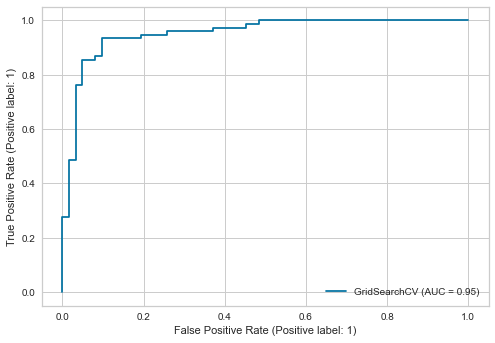

In [215]:
plot_roc_curve(XGB_grid_model, X_test_scaled, y_test);

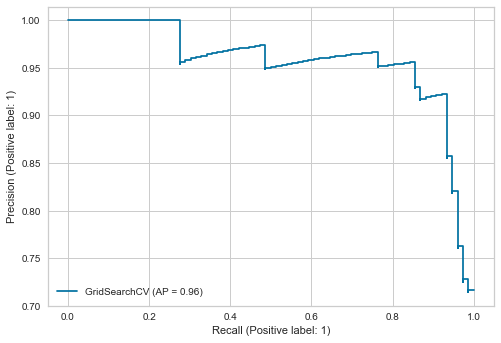

In [216]:
plot_precision_recall_curve(XGB_grid_model, X_test_scaled, y_test);

# Implement Decision Tree and Evaluate

**First take a close look at the models' accuracy scores for comparing the results given by Scaled, Not Scaled, Balanced and Not Balanced models**

In [255]:
accuracy_scores

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


[[43 19]
 [18 58]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.69      0.70        62
           1       0.75      0.76      0.76        76

    accuracy                           0.73       138
   macro avg       0.73      0.73      0.73       138
weighted avg       0.73      0.73      0.73       138

--------------------------------------------------------


,train_set,test_set
Accuracy,1.000,0.732
Precision,1.000,0.753
Recall,1.000,0.763
f1,1.000,0.758


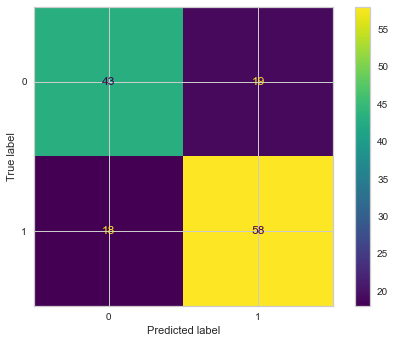

In [287]:
DT_model = DecisionTreeClassifier(class_weight="balanced", random_state=42)
DT_model.fit(X_train_scaled, y_train)
y_pred = DT_model.predict(X_test_scaled)
y_train_pred = DT_model.predict(X_train_scaled)

dt_f1 = f1_score(y_test, y_pred)
dt_acc = accuracy_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(DT_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

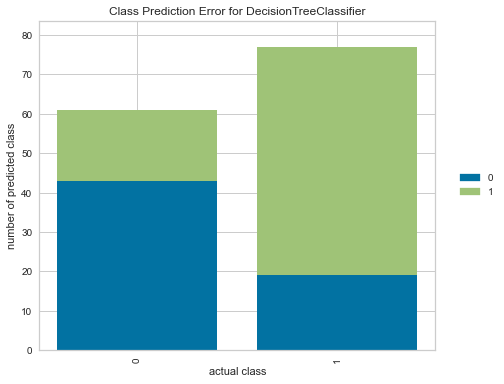

In [288]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(DT_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

## Cross-Validating Decision Tree (DT)

In [299]:
dt_xvalid_model = DecisionTreeClassifier(max_depth=None, random_state=42)

dt_xvalid_model_scores = cross_validate(dt_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
dt_xvalid_model_scores = pd.DataFrame(dt_xvalid_model_scores, index = range(1, 11))

dt_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.005,0.005,0.769,0.821,0.744,0.780
2,0.004,0.005,0.782,0.783,0.837,0.809
3,0.004,0.004,0.756,0.853,0.674,0.753
4,0.004,0.004,0.667,0.673,0.767,0.717
5,0.004,0.005,0.769,0.879,0.674,0.763
6,0.004,0.004,0.718,0.744,0.744,0.744
7,0.004,0.005,0.795,0.800,0.837,0.818
8,0.004,0.008,0.782,0.795,0.814,0.805
9,0.006,0.004,0.769,0.861,0.705,0.775
10,0.004,0.005,0.885,0.889,0.909,0.899


In [300]:
dt_xvalid_model_scores.mean()[2:]

test_accuracy    0.769
test_precision   0.810
test_recall      0.771
test_f1          0.786
dtype: float64

## Modelling Decision Tree (DT) with Best Parameters Using GridSeachCV

In [291]:
param_grid = {"splitter":["best", "random"],
              "max_features":[None, 3, 5, 7],
              "max_depth": [None, 4, 5, 6, 7, 8, 9, 10],
              "min_samples_leaf": [2, 3, 5],
              "min_samples_split": [2, 3, 5, 7, 9, 15]}

In [292]:
DT_grid_model = DecisionTreeClassifier(class_weight = "balanced", random_state=42)

DT_grid_model = GridSearchCV(estimator=DT_grid_model,
                            param_grid=param_grid,
                            scoring='recall',
                            n_jobs = -1, verbose = 2).fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


In [293]:
print(colored('\033[1mBest Parameters of GridSearchCV for Decision Tree Model:\033[0m', 'blue'), colored(DT_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for Decision Tree Model:\033[0m', 'blue'), colored(DT_grid_model.best_estimator_, 'cyan'))

Best Parameters of GridSearchCV for Decision Tree Model: {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 7, 'splitter': 'best'}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for Decision Tree Model: DecisionTreeClassifier(class_weight='balanced', max_depth=5, max_features=5,
                       min_samples_leaf=2, min_samples_split=7,
                       random_state=42)


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[[57  5]
 [ 7 69]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.90        62
           1       0.93      0.91      0.92        76

    accuracy                           0.91       138
   macro avg       0.91      0.91      0.91       138
weighted avg       0.91      0.91      0.91       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.878,0.913
Precision,0.889,0.932
Recall,0.891,0.908
f1,0.890,0.920


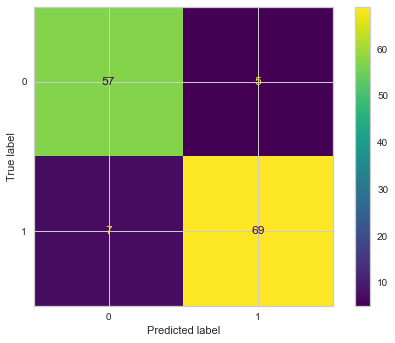

In [294]:
DT_grid_model.fit(X_train_scaled, y_train)
y_pred = DT_grid_model.predict(X_test_scaled)

y_train_pred = DT_grid_model.predict(X_train_scaled)

dt_grid_f1 = f1_score(y_test, y_pred)
dt_grid_acc = accuracy_score(y_test, y_pred)
dt_grid_recall = recall_score(y_test, y_pred)
dt_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(DT_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

## Feature Importance for Decision Tree (DT) Model

In [295]:
DT_model.feature_importances_

array([0.06133034, 0.08143838, 0.13854565, 0.03279224, 0.11580655,
       0.06791551, 0.02758706, 0.00839559, 0.02680743, 0.        ,
       0.02180528, 0.00424299, 0.03420438, 0.01015882, 0.36896978])

In [296]:
DT_feature_imp = pd.DataFrame(index = X.columns, data = DT_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
DT_feature_imp

,Feature Importance
ST_Slope_Up,0.369
Cholesterol,0.139
MaxHR,0.116
RestingBP,0.081
Oldpeak,0.068
Age,0.061
ExerciseAngina_Y,0.034
FastingBS,0.033
Sex_M,0.028
ChestPainType_NAP,0.027


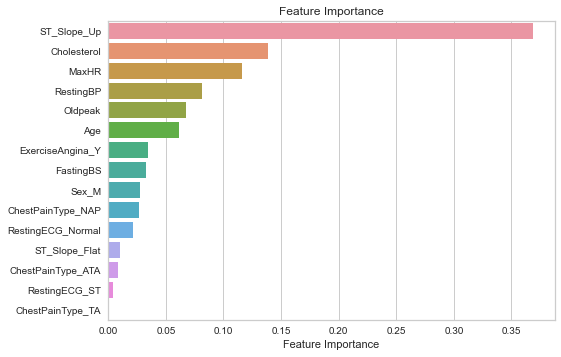

In [297]:
sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

**The feature that weighs too much on the estimation can SOMETIMES cause overfitting. We are curious about what happens to our model if we drop the feature with contribution. For this reason, the most important feature will be dropped and the scores will be checked again.**

In [301]:
X1 = X.drop(columns = ["ST_Slope_Up"]) 

In [302]:
X1.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y',
       'ST_Slope_Flat'],
      dtype='object')

In [304]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.15, random_state=42)

[[43 19]
 [18 58]]
              precision    recall  f1-score   support

           0       0.70      0.69      0.70        62
           1       0.75      0.76      0.76        76

    accuracy                           0.73       138
   macro avg       0.73      0.73      0.73       138
weighted avg       0.73      0.73      0.73       138

[[43 19]
 [18 58]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.69      0.70        62
           1       0.75      0.76      0.76        76

    accuracy                           0.73       138
   macro avg       0.73      0.73      0.73       138
weighted avg       0.73      0.73      0.73       138

--------------------------------------------------------


,train_set,test_set
Accuracy,1.000,0.732
Precision,1.000,0.753
Recall,1.000,0.763
f1,1.000,0.758


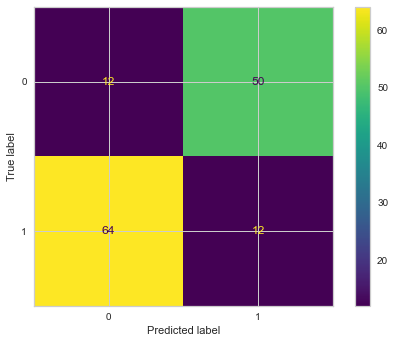

In [305]:
operations = [("scaler", MinMaxScaler()), ("xgb", DecisionTreeClassifier(class_weight="balanced", random_state=42))]

RF_pipe_model = Pipeline(steps=operations)
RF_pipe_model.get_params()
RF_pipe_model.fit(X_train, y_train)

y_pred = RF_pipe_model.predict(X_test)
y_train_pred = RF_pipe_model.predict(X_train)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

rf_pipe_f1 = f1_score(y_test, y_pred)
rf_pipe_acc = accuracy_score(y_test, y_pred)
rf_pipe_recall = recall_score(y_test, y_pred)
rf_pipe_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(RF_pipe_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

**In general, droping the feature that weighs too much on the estimation did NOT make any sense. Both True Positive predictions and False Negative ones increadably decreased.** 

## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

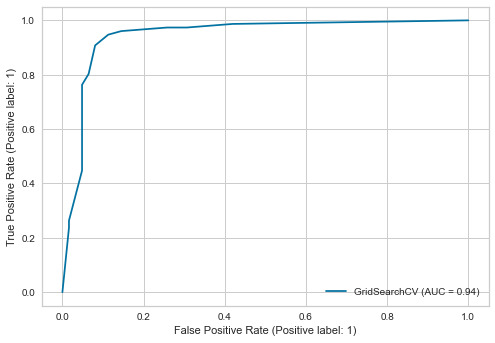

In [306]:
plot_roc_curve(DT_grid_model, X_test_scaled, y_test);

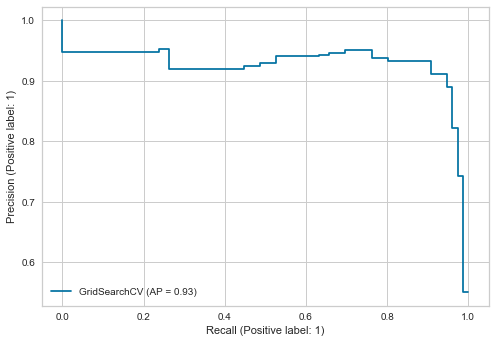

In [307]:
plot_precision_recall_curve(DT_grid_model, X_test_scaled, y_test);

# Implement Random Forest and Evaluate

**First take a close look at the models' accuracy scores for comparing the results given by Scaled, Not Scaled, Balanced and Not Balanced models**

In [225]:
accuracy_scores

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


[[53  9]
 [ 5 71]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        62
           1       0.89      0.93      0.91        76

    accuracy                           0.90       138
   macro avg       0.90      0.89      0.90       138
weighted avg       0.90      0.90      0.90       138

--------------------------------------------------------


,train_set,test_set
Accuracy,1.000,0.899
Precision,1.000,0.887
Recall,1.000,0.934
f1,1.000,0.910


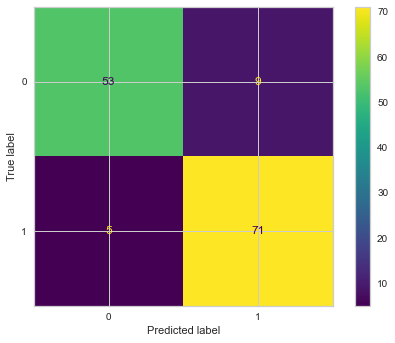

In [260]:
RF_model = RandomForestClassifier(class_weight="balanced", random_state=101)
RF_model.fit(X_train_scaled, y_train)
y_pred = RF_model.predict(X_test_scaled)
y_train_pred = RF_model.predict(X_train_scaled)

rf_f1 = f1_score(y_test, y_pred)
rf_acc = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(RF_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

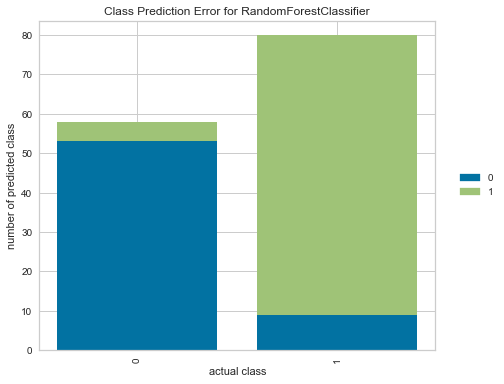

In [261]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(RF_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

## Cross-Validating Random Forest (RF)

In [262]:
rf_xvalid_model = RandomForestClassifier(max_depth=None, random_state=101)

rf_xvalid_model_scores = cross_validate(rf_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
rf_xvalid_model_scores = pd.DataFrame(rf_xvalid_model_scores, index = range(1, 11))

rf_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.213,0.018,0.872,0.851,0.930,0.889
2,0.206,0.020,0.846,0.830,0.907,0.867
3,0.215,0.019,0.910,0.909,0.930,0.920
4,0.208,0.019,0.885,0.886,0.907,0.897
5,0.208,0.024,0.885,0.886,0.907,0.897
6,0.209,0.018,0.846,0.830,0.907,0.867
7,0.200,0.019,0.795,0.776,0.884,0.826
8,0.204,0.019,0.833,0.841,0.860,0.851
9,0.199,0.018,0.782,0.846,0.750,0.795
10,0.194,0.018,0.923,0.913,0.955,0.933


In [263]:
rf_xvalid_model_scores.mean()[2:]

test_accuracy    0.858
test_precision   0.857
test_recall      0.894
test_f1          0.874
dtype: float64

## Modelling Random Forest (RF) with Best Parameters Using GridSeachCV

In [243]:
param_grid = {'n_estimators':[50, 100, 300],
             'max_features':[2, 3, 4],
             'max_depth':[3, 5, 7, 9],
             'min_samples_split':[2, 5, 8]}

In [264]:
RF_grid_model = RandomForestClassifier(random_state=101)

RF_grid_model = GridSearchCV(estimator=RF_grid_model, 
                             param_grid=param_grid, 
                             scoring = "recall", 
                             n_jobs = -1, verbose = 2).fit(X_train_scaled, y_train)  # Whatch out, fit() can also be used here

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [265]:
print(colored('\033[1mBest Parameters of GridSearchCV for Random Forest Model:\033[0m', 'blue'), colored(RF_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for RF Model:\033[0m', 'blue'), colored(RF_grid_model.best_estimator_, 'cyan'))

Best Parameters of GridSearchCV for Random Forest Model: {'max_depth': 5, 'max_features': 3, 'min_samples_split': 8, 'n_estimators': 50}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for RF Model: RandomForestClassifier(max_depth=5, max_features=3, min_samples_split=8,
                       n_estimators=50, random_state=101)


[[50 12]
 [ 3 73]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        62
           1       0.86      0.96      0.91        76

    accuracy                           0.89       138
   macro avg       0.90      0.88      0.89       138
weighted avg       0.90      0.89      0.89       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.890,0.891
Precision,0.878,0.859
Recall,0.931,0.961
f1,0.903,0.907


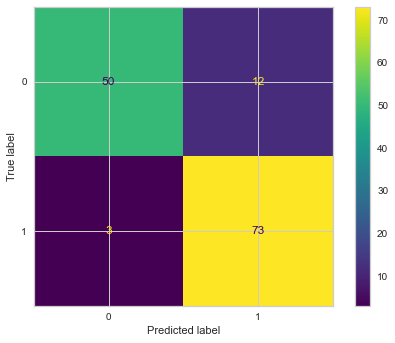

In [266]:
y_pred = RF_grid_model.predict(X_test_scaled)
y_train_pred = RF_grid_model.predict(X_train_scaled)

rf_grid_f1 = f1_score(y_test, y_pred)
rf_grid_acc = accuracy_score(y_test, y_pred)
rf_grid_recall = recall_score(y_test, y_pred)
rf_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(RF_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

##  Feature Importance for Random Forest (RF) Model

In [267]:
RF_model.feature_importances_

array([0.09127286, 0.07379526, 0.10632464, 0.02535356, 0.1049907 ,
       0.11912291, 0.03670682, 0.03225268, 0.02561564, 0.01000144,
       0.01829766, 0.00932166, 0.09384744, 0.10801303, 0.14508368])

In [268]:
RF_feature_imp = pd.DataFrame(index = X.columns, data = RF_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
RF_feature_imp

,Feature Importance
ST_Slope_Up,0.145
Oldpeak,0.119
ST_Slope_Flat,0.108
Cholesterol,0.106
MaxHR,0.105
ExerciseAngina_Y,0.094
Age,0.091
RestingBP,0.074
Sex_M,0.037
ChestPainType_ATA,0.032


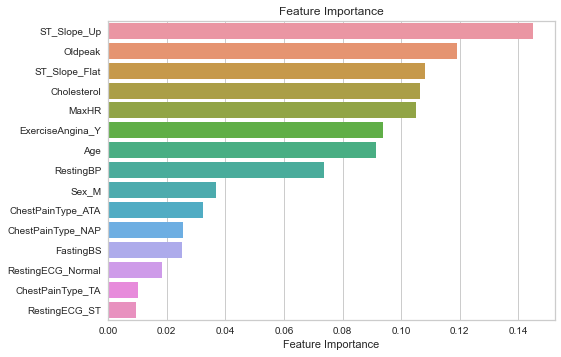

In [269]:
sns.barplot(x=RF_feature_imp["Feature Importance"], y=RF_feature_imp.index)
plt.title("Feature Importance")
plt.show()

**Let's compare the results with the ones found via Decision Tree**

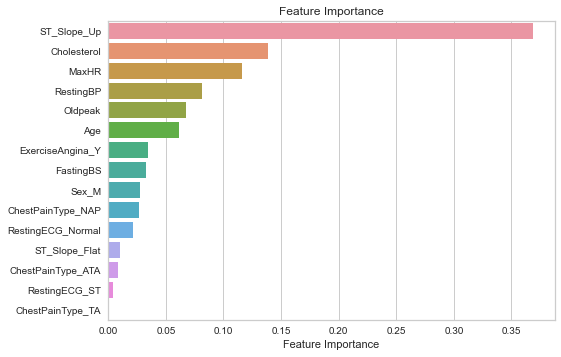

In [308]:
sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

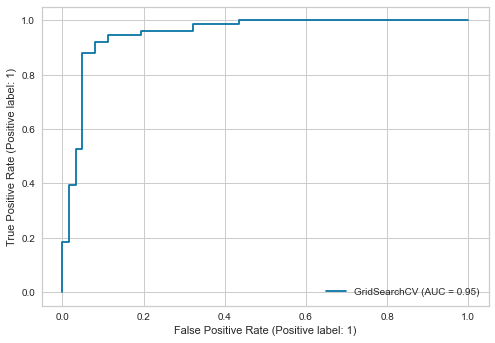

In [270]:
plot_roc_curve(RF_grid_model, X_test_scaled, y_test);

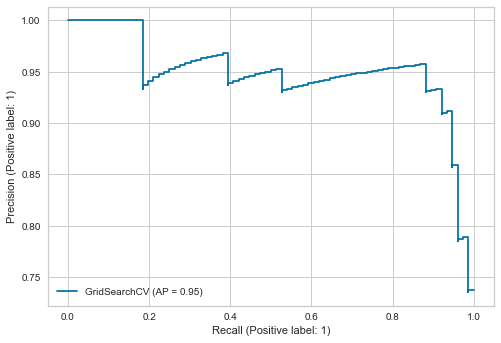

In [271]:
plot_precision_recall_curve(RF_grid_model, X_test_scaled, y_test);

# Implement KNN and Evaluate

**First take a close look at the models' accuracy scores for comparing the results given by Scaled, Not Scaled, Balanced and Not Balanced models**

In [309]:
accuracy_scores

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


[[50 12]
 [10 66]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        62
           1       0.85      0.87      0.86        76

    accuracy                           0.84       138
   macro avg       0.84      0.84      0.84       138
weighted avg       0.84      0.84      0.84       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.883,0.841
Precision,0.881,0.846
Recall,0.912,0.868
f1,0.896,0.857


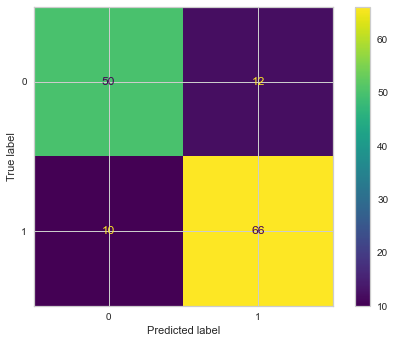

In [317]:
KNN_model = KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree")
KNN_model.fit(X_train_scaled, y_train)
y_pred = KNN_model.predict(X_test_scaled)
y_train_pred = KNN_model.predict(X_train_scaled)

knn_f1 = f1_score(y_test, y_pred)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
knn_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(KNN_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [318]:
y_pred_proba = KNN_model.predict_proba(X_test_scaled)

In [319]:
pd.DataFrame(y_pred_proba)

,0,1
0,0.000,1.000
1,0.200,0.800
2,0.200,0.800
3,0.800,0.200
4,0.400,0.600
...,...,...
133,0.800,0.200
134,1.000,0.000
135,0.600,0.400
136,0.000,1.000


In [320]:
my_dict = {"Actual": y_test, "Pred": y_pred, "Proba_1": y_pred_proba[:,1], "Proba_0":y_pred_proba[:,0]}

In [321]:
pd.DataFrame.from_dict(my_dict).sample(10)

,Actual,Pred,Proba_1,Proba_0
178,0,0,0.000,1.000
894,0,1,0.600,0.400
363,1,1,0.800,0.200
299,1,1,0.600,0.400
793,1,1,1.000,0.000
523,1,1,0.800,0.200
543,1,1,1.000,0.000
159,0,0,0.000,1.000
879,1,0,0.000,1.000
498,1,1,1.000,0.000


## Cross-Validating K-Nearest Neighbor (KNN)

In [323]:
knn_xvalid_model = KNeighborsClassifier(n_neighbors=5)

knn_xvalid_model_scores = cross_validate(knn_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
knn_xvalid_model_scores = pd.DataFrame(scores, index = range(1, 11))

knn_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.027,0.005,0.782,0.783,0.837,0.809
2,0.028,0.004,0.846,0.860,0.860,0.860
3,0.026,0.005,0.872,0.884,0.884,0.884
4,0.026,0.004,0.833,0.875,0.814,0.843
5,0.025,0.005,0.910,0.929,0.907,0.918
6,0.022,0.004,0.833,0.857,0.837,0.847
7,0.024,0.005,0.885,0.870,0.930,0.899
8,0.025,0.005,0.846,0.844,0.884,0.864
9,0.024,0.005,0.808,0.892,0.750,0.815
10,0.024,0.004,0.923,0.913,0.955,0.933


In [324]:
knn_xvalid_model_scores.mean()[2:]

test_accuracy    0.854
test_precision   0.871
test_recall      0.866
test_f1          0.867
dtype: float64

## Elbow Method for Choosing Reasonable K Values

In [325]:
test_error_rates = []


for k in range(1, 30):
    KNN_model = KNeighborsClassifier(n_neighbors=k)
    KNN_model.fit(X_train_scaled, y_train) 
   
    y_test_pred = KNN_model.predict(X_test_scaled)
    
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    test_error_rates.append(test_error)

In [326]:
test_error_rates

[0.1594202898550725,
 0.2246376811594203,
 0.14492753623188404,
 0.16666666666666663,
 0.1594202898550725,
 0.16666666666666663,
 0.14492753623188404,
 0.14492753623188404,
 0.14492753623188404,
 0.14492753623188404,
 0.1376811594202898,
 0.1376811594202898,
 0.13043478260869568,
 0.13043478260869568,
 0.13043478260869568,
 0.13043478260869568,
 0.1376811594202898,
 0.14492753623188404,
 0.13043478260869568,
 0.1376811594202898,
 0.13043478260869568,
 0.13043478260869568,
 0.13043478260869568,
 0.13043478260869568,
 0.1376811594202898,
 0.1376811594202898,
 0.14492753623188404,
 0.14492753623188404,
 0.1376811594202898]

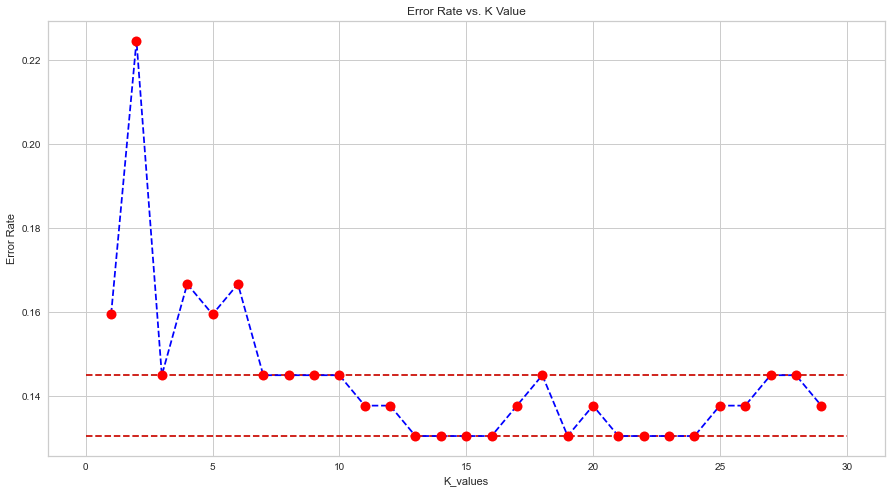

In [330]:
plt.figure(figsize=(15, 8))
plt.plot(range(1, 30), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=0.14492753623188404, xmin=0, xmax=30, colors='r', linestyles="--")
plt.hlines(y=0.13043478260869568, xmin=0, xmax=30, colors='r', linestyles="--");

## GridsearchCV for Choosing Reasonable K Values

In [331]:
k_values= range(1, 30)
param_grid = {"n_neighbors": k_values, "p": [1, 2], "weights": ['uniform', "distance"]}

In [332]:
KNN_grid = KNeighborsClassifier()

In [333]:
KNN_grid_model = GridSearchCV(KNN_grid, param_grid, cv=10, scoring='accuracy')

In [334]:
KNN_grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Let's look at the best parameters & estimator found by GridSearchCV.

In [335]:
print(colored('\033[1mBest Parameters of GridSearchCV for KNN Model:\033[0m', 'blue'), colored(KNN_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for KNN Model:\033[0m', 'blue'), colored(KNN_grid_model.best_estimator_, 'cyan'))

Best Parameters of GridSearchCV for KNN Model: {'n_neighbors': 26, 'p': 2, 'weights': 'distance'}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for KNN Model: KNeighborsClassifier(n_neighbors=26, weights='distance')


WITH K=26
-------------------
[[50 12]
 [10 66]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        62
           1       0.85      0.87      0.86        76

    accuracy                           0.84       138
   macro avg       0.84      0.84      0.84       138
weighted avg       0.84      0.84      0.84       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.860,0.841
Precision,0.855,0.846
Recall,0.900,0.868
f1,0.877,0.857


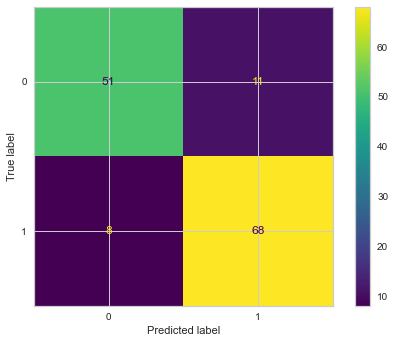

In [339]:
# NOW WITH K=26

KNN_model = KNeighborsClassifier(n_neighbors=26, p=2)
KNN_model.fit(X_train_scaled, y_train)
pred = KNN_model.predict(X_test_scaled)
y_train_pred = KNN_model.predict(X_train_scaled)

knn26_f1 = f1_score(y_test, y_pred)
knn26_acc = accuracy_score(y_test, y_pred)
knn26_recall = recall_score(y_test, y_pred)
knn26_auc = roc_auc_score(y_test, y_pred)

print('WITH K=26')
print('-------------------')
print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(KNN_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

WITH K=13
-------------------
[[50 12]
 [10 66]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        62
           1       0.85      0.87      0.86        76

    accuracy                           0.84       138
   macro avg       0.84      0.84      0.84       138
weighted avg       0.84      0.84      0.84       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.869,0.841
Precision,0.863,0.846
Recall,0.907,0.868
f1,0.885,0.857


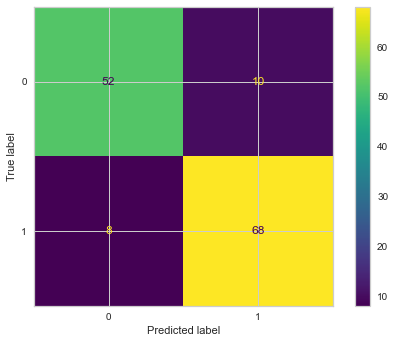

In [340]:
# NOW WITH K=13

KNN_model = KNeighborsClassifier(n_neighbors=13, p=2)
KNN_model.fit(X_train_scaled, y_train)
pred = KNN_model.predict(X_test_scaled)
y_train_pred = KNN_model.predict(X_train_scaled)

knn13_f1 = f1_score(y_test, y_pred)
knn13_acc = accuracy_score(y_test, y_pred)
knn13_recall = recall_score(y_test, y_pred)
knn13_auc = roc_auc_score(y_test, y_pred)

print('WITH K=13')
print('-------------------')
print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(KNN_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

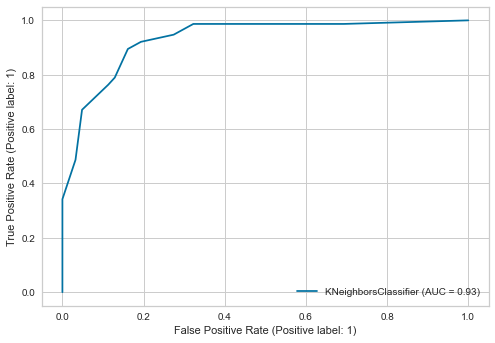

In [341]:
plot_roc_curve(KNN_model, X_test_scaled, y_test);

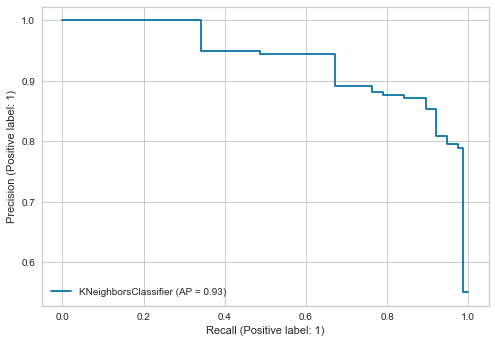

In [342]:
plot_precision_recall_curve(KNN_model, X_test_scaled, y_test);

# Implement GB and Evaluate

**First take a close look at the models' accuracy scores for comparing the results given by Scaled, Not Scaled, Balanced and Not Balanced models**

In [376]:
accuracy_scores

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


<IPython.core.display.Javascript object>

[[56  6]
 [ 5 71]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        62
           1       0.92      0.93      0.93        76

    accuracy                           0.92       138
   macro avg       0.92      0.92      0.92       138
weighted avg       0.92      0.92      0.92       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.940,0.920
Precision,0.937,0.922
Recall,0.956,0.934
f1,0.946,0.928


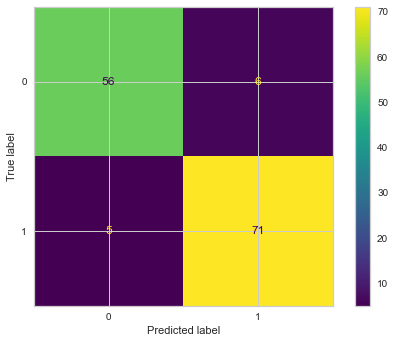

In [377]:
GB_model = GradientBoostingClassifier(random_state=42)
GB_model.fit(X_train_scaled, y_train)
y_pred = GB_model.predict(X_test_scaled)
y_train_pred = GB_model.predict(X_train_scaled)

gb_f1 = f1_score(y_test, y_pred)
gb_acc = accuracy_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(GB_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

**Cross-checking the model by predictions in Train Set for consistency**

[[320  28]
 [ 19 413]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       348
           1       0.94      0.96      0.95       432

    accuracy                           0.94       780
   macro avg       0.94      0.94      0.94       780
weighted avg       0.94      0.94      0.94       780

--------------------------------------------------------


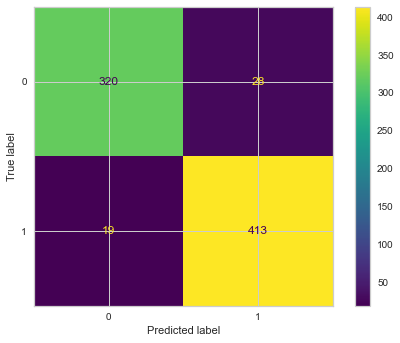

In [378]:
y_train_pred = GB_model.predict(X_train_scaled)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(GB_model, X_train_scaled, y_train);

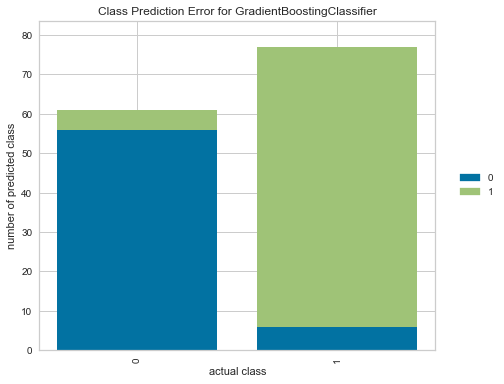

In [379]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(GB_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

##  Cross-Validating GradientBoosting (GB)

In [380]:
gb_xvalid_model = GradientBoostingClassifier(random_state=42)

gb_xvalid_model_scores = cross_validate(gb_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"], cv = 10)
gb_xvalid_model_scores = pd.DataFrame(gb_xvalid_model_scores, index = range(1, 11))

gb_xvalid_model_scores

<IPython.core.display.Javascript object>

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
1,0.211,0.005,0.833,0.832,0.830,0.831
2,0.216,0.005,0.833,0.835,0.828,0.830
3,0.180,0.006,0.885,0.888,0.879,0.882
4,0.174,0.005,0.872,0.870,0.870,0.870
5,0.278,0.008,0.885,0.883,0.885,0.884
6,0.238,0.005,0.859,0.867,0.851,0.855
7,0.185,0.005,0.897,0.899,0.894,0.896
8,0.212,0.006,0.833,0.832,0.830,0.831
9,0.172,0.004,0.833,0.833,0.839,0.833
10,0.166,0.005,0.872,0.869,0.873,0.870


In [381]:
gb_xvalid_model_scores.mean()

fit_time               0.203
score_time             0.005
test_accuracy          0.860
test_precision_macro   0.861
test_recall_macro      0.858
test_f1_macro          0.858
dtype: float64

## Feature Importance for GradientBoosting (GB) Model

In [382]:
GB_model.feature_importances_

array([0.04547774, 0.04765723, 0.1216169 , 0.02435517, 0.06266039,
       0.06187126, 0.04401044, 0.02469931, 0.03502063, 0.01117504,
       0.00841365, 0.00272764, 0.06939297, 0.02077538, 0.42014625])

In [383]:
GB_feature_imp = pd.DataFrame(index = X.columns, data = GB_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
GB_feature_imp

,Feature Importance
ST_Slope_Up,0.420
Cholesterol,0.122
ExerciseAngina_Y,0.069
MaxHR,0.063
Oldpeak,0.062
RestingBP,0.048
Age,0.045
Sex_M,0.044
ChestPainType_NAP,0.035
ChestPainType_ATA,0.025


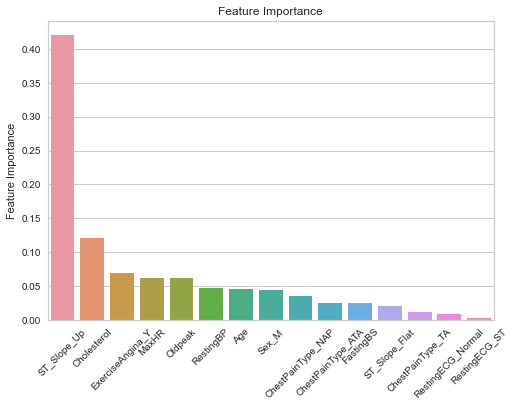

In [384]:
sns.barplot(y=GB_feature_imp["Feature Importance"], x=GB_feature_imp.index)
plt.title("Feature Importance")
plt.xticks(rotation=45)
plt.show()

## Modelling GradientBoosting (GB) Model with Best Parameters Using GridSeachCV

In [385]:
# Computing the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.15, 0.25, 0.5, 0.6, 0.75, 0.85, 1]

for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, random_state=42)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

<IPython.core.display.Javascript object>

Learning rate:  0.05
Accuracy score (training): 0.867
Accuracy score (test): 0.862



<IPython.core.display.Javascript object>

Learning rate:  0.1
Accuracy score (training): 0.894
Accuracy score (test): 0.899



<IPython.core.display.Javascript object>

Learning rate:  0.15
Accuracy score (training): 0.903
Accuracy score (test): 0.913



<IPython.core.display.Javascript object>

Learning rate:  0.25
Accuracy score (training): 0.921
Accuracy score (test): 0.913



<IPython.core.display.Javascript object>

Learning rate:  0.5
Accuracy score (training): 0.940
Accuracy score (test): 0.920



<IPython.core.display.Javascript object>

Learning rate:  0.6
Accuracy score (training): 0.953
Accuracy score (test): 0.899



<IPython.core.display.Javascript object>

Learning rate:  0.75
Accuracy score (training): 0.969
Accuracy score (test): 0.884



<IPython.core.display.Javascript object>

Learning rate:  0.85
Accuracy score (training): 0.965
Accuracy score (test): 0.884



<IPython.core.display.Javascript object>

Learning rate:  1
Accuracy score (training): 0.969
Accuracy score (test): 0.812



In [386]:
param_grid = {"n_estimators":[100, 200, 300],
             "subsample":[0.5, 1], "max_features" : [None, 2, 3, 4], "learning_rate": [0.2, 0.5, 0.6, 0.75, 0.85, 1.0, 1.25, 1.5]}  # 'max_depth':[3,4,5,6]

In [387]:
GB_grid_model = GradientBoostingClassifier(random_state=42)

GB_grid_model = GridSearchCV(GB_grid_model, param_grid, scoring = "f1", verbose=2, n_jobs = -1).fit(X_train, y_train)

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [388]:
print(colored('\033[1mBest Parameters of GridSearchCV for Gradient Boosting Model:\033[0m', 'blue'), colored(GB_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for Gradient Boosting Model:\033[0m', 'blue'), colored(GB_grid_model.best_estimator_, 'cyan'))

Best Parameters of GridSearchCV for Gradient Boosting Model: {'learning_rate': 0.2, 'max_features': 2, 'n_estimators': 100, 'subsample': 1}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for Gradient Boosting Model: GradientBoostingClassifier(learning_rate=0.2, max_features=2, random_state=42,
                           subsample=1)


[[47 15]
 [ 8 68]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        62
           1       0.82      0.89      0.86        76

    accuracy                           0.83       138
   macro avg       0.84      0.83      0.83       138
weighted avg       0.84      0.83      0.83       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.806,0.833
Precision,0.828,0.819
Recall,0.822,0.895
f1,0.825,0.855


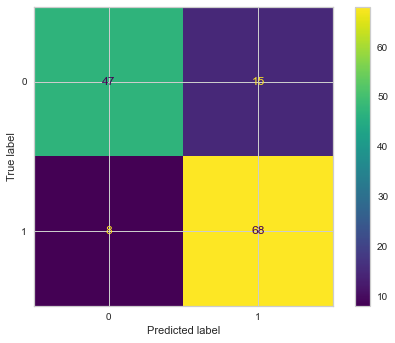

In [389]:
y_pred = GB_grid_model.predict(X_test_scaled)
y_train_pred = GB_grid_model.predict(X_train_scaled)

gb_grid_f1 = f1_score(y_test, y_pred)
gb_grid_acc = accuracy_score(y_test, y_pred)
gb_grid_recall = recall_score(y_test, y_pred)
gb_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(GB_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

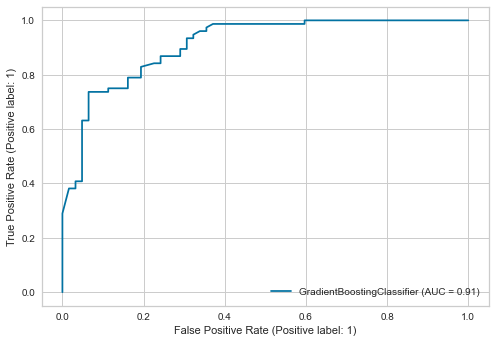

In [390]:
plot_roc_curve(GB_model, X_test, y_test);

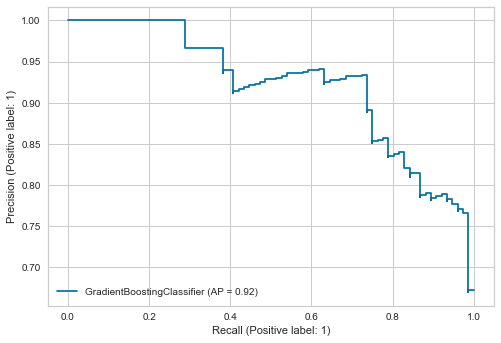

In [391]:
plot_precision_recall_curve(GB_model, X_test, y_test);

# Implement AB and Evaluate

**First take a close look at the models' accuracy scores for comparing the results given by Scaled, Not Scaled, Balanced and Not Balanced models**

In [373]:
accuracy_scores

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


[[52 10]
 [ 7 69]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        62
           1       0.87      0.91      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.87       138
weighted avg       0.88      0.88      0.88       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.879,0.877
Precision,0.889,0.873
Recall,0.894,0.908
f1,0.891,0.890


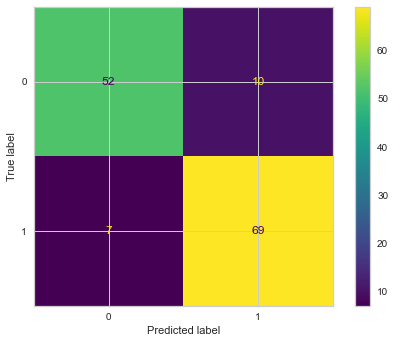

In [344]:
AB_model = AdaBoostClassifier(n_estimators=50, random_state=101)
AB_model.fit(X_train, y_train)
y_pred = AB_model.predict(X_test)
y_train_pred = AB_model.predict(X_train)

ab_f1 = f1_score(y_test, y_pred)
ab_acc = accuracy_score(y_test, y_pred)
ab_recall = recall_score(y_test, y_pred)
ab_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_model, X_test, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

**Cross-checking the model by predictions in Train Set for consistency**

[[300  48]
 [ 46 386]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       348
           1       0.89      0.89      0.89       432

    accuracy                           0.88       780
   macro avg       0.88      0.88      0.88       780
weighted avg       0.88      0.88      0.88       780

--------------------------------------------------------


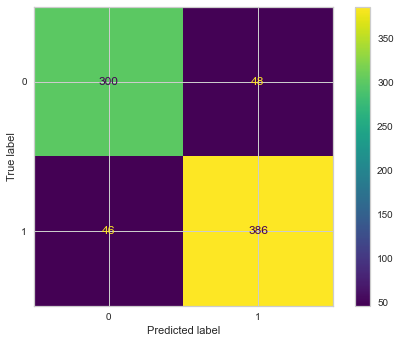

In [345]:
y_train_pred = AB_model.predict(X_train)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_model, X_train, y_train);

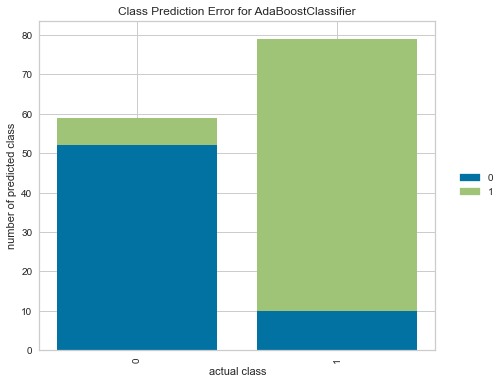

In [346]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(AB_model)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.poof();

## Cross-Validating AdaBoostingBoosting (AB)

In [349]:
ab_xvalid_model = AdaBoostClassifier(n_estimators=50, random_state=101)

ab_xvalid_model_scores = cross_validate(ab_xvalid_model, X_train, y_train, scoring = ['accuracy', 'precision','recall', 'f1'], cv = 10)
ab_xvalid_model_scores = pd.DataFrame(scores, index = range(1, 11))

ab_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.027,0.005,0.782,0.783,0.837,0.809
2,0.028,0.004,0.846,0.860,0.860,0.860
3,0.026,0.005,0.872,0.884,0.884,0.884
4,0.026,0.004,0.833,0.875,0.814,0.843
5,0.025,0.005,0.910,0.929,0.907,0.918
6,0.022,0.004,0.833,0.857,0.837,0.847
7,0.024,0.005,0.885,0.870,0.930,0.899
8,0.025,0.005,0.846,0.844,0.884,0.864
9,0.024,0.005,0.808,0.892,0.750,0.815
10,0.024,0.004,0.923,0.913,0.955,0.933


In [350]:
ab_xvalid_model_scores.mean()

fit_time         0.025
score_time       0.004
test_accuracy    0.854
test_precision   0.871
test_recall      0.866
test_f1          0.867
dtype: float64

## The Visualization of the Tree

In [351]:
AB_model = AdaBoostClassifier(n_estimators=3, random_state=42)
AB_model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=3, random_state=42)

In [353]:
df.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST',
       'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

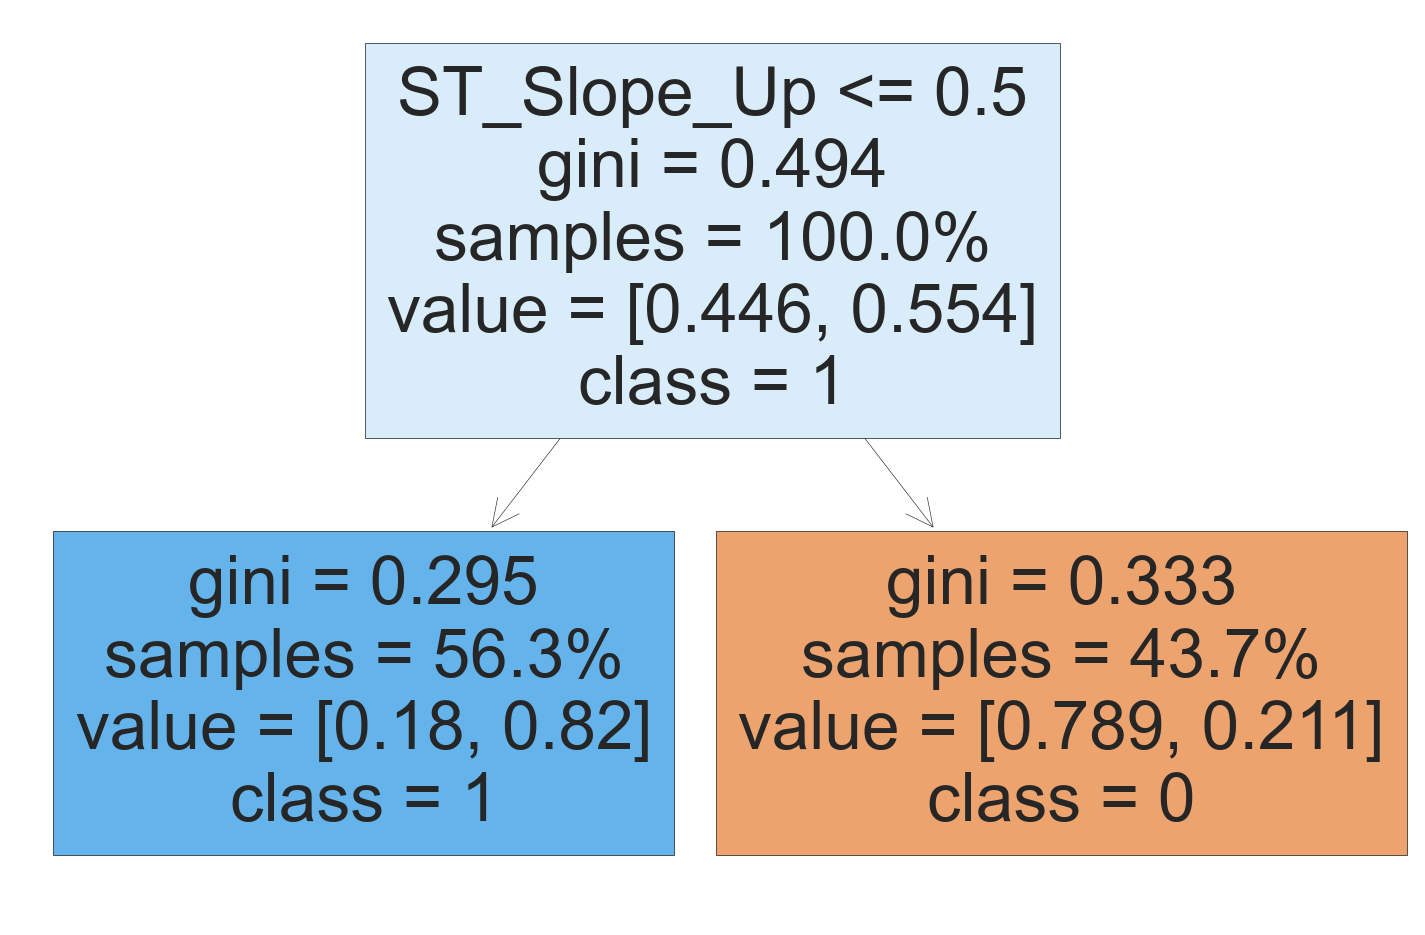

In [354]:
features = list(X.columns)
targets = df["HeartDisease"].astype("str")

plt.figure(figsize=(12, 8),dpi=150)
plot_tree(AB_model.estimators_[0], filled=True, feature_names=features, class_names=targets.unique(), proportion=True);

## Analyzing Performance While Weak Learners Are Added

In [355]:
error_rates = []

for n in range(1, 100):
    
    AB_model = AdaBoostClassifier(n_estimators=n)
    AB_model.fit(X_train, y_train)
    preds = AB_model.predict(X_test)
    err = 1 - f1_score(y_test, preds)
    
    error_rates.append(err)

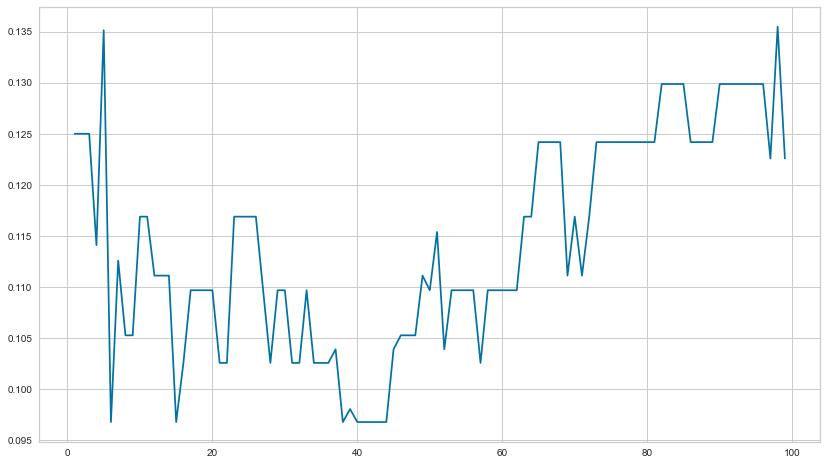

In [356]:
plt.figure(figsize=(14, 8))
plt.plot(range(1,100), error_rates);

## Feature Importance for AdaBoostingBoosting (AB) Model

In [358]:
AB_model.feature_importances_

array([0.18181818, 0.14141414, 0.2020202 , 0.02020202, 0.14141414,
       0.13131313, 0.02020202, 0.02020202, 0.03030303, 0.02020202,
       0.        , 0.01010101, 0.02020202, 0.03030303, 0.03030303])

In [359]:
AB_feature_imp = pd.DataFrame(index = X.columns, data = AB_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
AB_feature_imp

,Feature Importance
Cholesterol,0.202
Age,0.182
RestingBP,0.141
MaxHR,0.141
Oldpeak,0.131
ChestPainType_NAP,0.030
ST_Slope_Flat,0.030
ST_Slope_Up,0.030
FastingBS,0.020
Sex_M,0.020


In [360]:
imp_feats = AB_feature_imp.sort_values("Feature Importance")

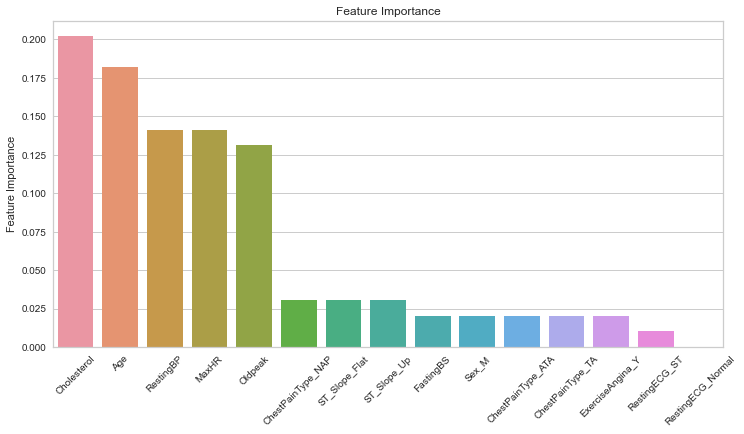

In [361]:
plt.figure(figsize=(12,6))
sns.barplot(y=AB_feature_imp["Feature Importance"], x=AB_feature_imp.index)

plt.title("Feature Importance")
plt.xticks(rotation=45)
plt.show()

## Modelling AdaBoosting (AB) with Best Parameters Using GridSearchCV

In [363]:
# Computing the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.15, 0.25, 0.5, 0.6, 0.75, 0.85, 1]

for learning_rate in learning_rates:
    ab = AdaBoostClassifier(n_estimators=20, learning_rate = learning_rate, random_state=42)
    ab.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(ab.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(ab.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.806
Accuracy score (test): 0.855

Learning rate:  0.1
Accuracy score (training): 0.817
Accuracy score (test): 0.855

Learning rate:  0.15
Accuracy score (training): 0.828
Accuracy score (test): 0.855

Learning rate:  0.25
Accuracy score (training): 0.862
Accuracy score (test): 0.884

Learning rate:  0.5
Accuracy score (training): 0.877
Accuracy score (test): 0.884

Learning rate:  0.6
Accuracy score (training): 0.883
Accuracy score (test): 0.884

Learning rate:  0.75
Accuracy score (training): 0.879
Accuracy score (test): 0.870

Learning rate:  0.85
Accuracy score (training): 0.873
Accuracy score (test): 0.870

Learning rate:  1
Accuracy score (training): 0.868
Accuracy score (test): 0.877



In [364]:
param_grid = {"n_estimators": [15, 20, 100, 500], "learning_rate": [0.2, 0.5, 0.6, 0.75, 0.85, 1.0, 1.25, 1.5]}

In [365]:
AB_grid_model = AdaBoostClassifier(random_state=42)
AB_grid_model = GridSearchCV(AB_grid_model, param_grid, cv=5, scoring= 'f1')

In [366]:
AB_grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.2, 0.5, 0.6, 0.75, 0.85, 1.0, 1.25,
                                           1.5],
                         'n_estimators': [15, 20, 100, 500]},
             scoring='f1')

In [367]:
print(colored('\033[1mBest Parameters of GridSearchCV for AdaBoosting Model:\033[0m', 'blue'), colored(AB_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for AdaBoosting Model:\033[0m', 'blue'), colored(AB_grid_model.best_estimator_, 'cyan'))

Best Parameters of GridSearchCV for AdaBoosting Model: {'learning_rate': 0.5, 'n_estimators': 15}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for AdaBoosting Model: AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=42)


[[51 11]
 [ 6 70]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.82      0.86        62
           1       0.86      0.92      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.87       138
weighted avg       0.88      0.88      0.88       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.879,0.877
Precision,0.889,0.864
Recall,0.894,0.921
f1,0.891,0.892


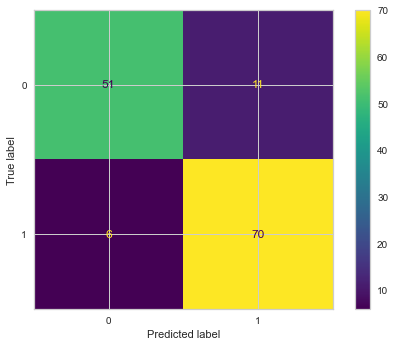

In [368]:
y_pred = AB_grid_model.predict(X_test)

ab_grid_f1 = f1_score(y_test, y_pred)
ab_grid_acc = accuracy_score(y_test, y_pred)
ab_grid_recall = recall_score(y_test, y_pred)
ab_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_grid_model, X_test, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

[[291  57]
 [ 45 387]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       348
           1       0.87      0.90      0.88       432

    accuracy                           0.87       780
   macro avg       0.87      0.87      0.87       780
weighted avg       0.87      0.87      0.87       780

--------------------------------------------------------


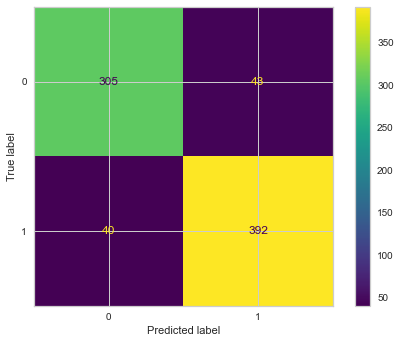

In [369]:
y_train_pred = AB_grid_model.predict(X_train)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_model, X_train, y_train);

## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

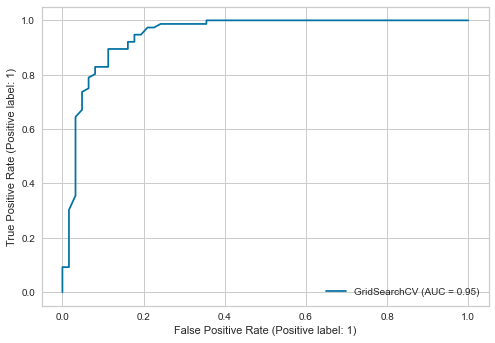

In [370]:
plot_roc_curve(AB_grid_model, X_test, y_test);

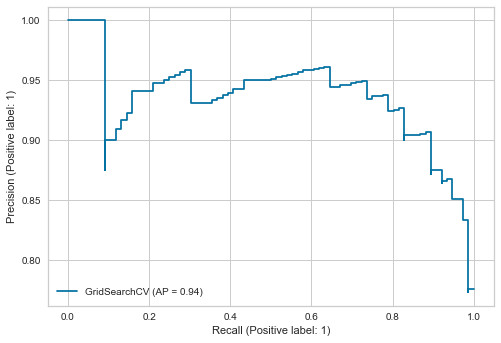

In [371]:
plot_precision_recall_curve(AB_grid_model, X_test, y_test);

# Implement SVM and Evaluate

**First take a close look at the models' accuracy scores for comparing the results given by Scaled, Not Scaled, Balanced and Not Balanced models**

In [374]:
accuracy_scores

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


[[54  8]
 [ 7 69]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        62
           1       0.90      0.91      0.90        76

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.883,0.891
Precision,0.881,0.896
Recall,0.912,0.908
f1,0.896,0.902


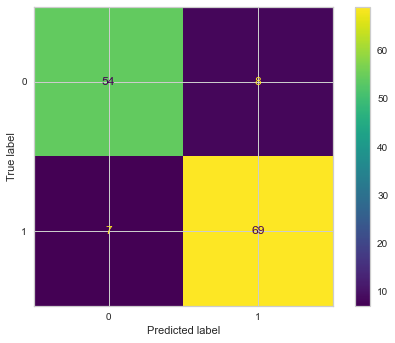

In [415]:
SVM_model = SVC(random_state=42)
SVM_model.fit(X_train_scaled, y_train)
y_pred = SVM_model.predict(X_test_scaled)
y_train_pred = SVM_model.predict(X_train_scaled)

svm_f1 = f1_score(y_test, y_pred)
svm_acc = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(SVM_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

**Cross-checking the model by predictions in Train Set for consistency**

[[295  53]
 [ 38 394]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       348
           1       0.88      0.91      0.90       432

    accuracy                           0.88       780
   macro avg       0.88      0.88      0.88       780
weighted avg       0.88      0.88      0.88       780

--------------------------------------------------------


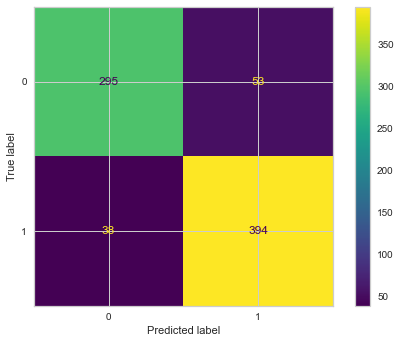

In [416]:
y_train_pred = SVM_model.predict(X_train_scaled)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(SVM_model, X_train_scaled, y_train);

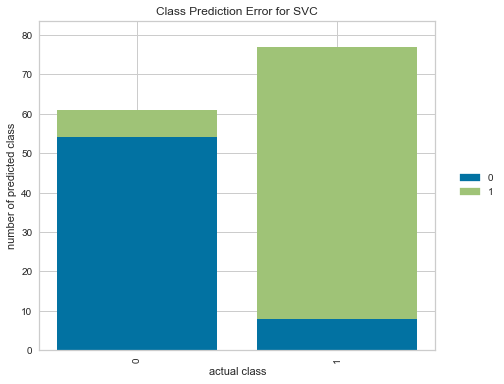

In [417]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(SVM_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

## Cross-Validating SVM

In [419]:
svm_xvalid_model = SVC()

svm_xvalid_model_scores = cross_validate(svm_xvalid_model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1'], cv = 10)
svm_xvalid_model_scores = pd.DataFrame(svm_xvalid_model_scores, index = range(1, 11))

svm_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.016,0.009,0.833,0.800,0.930,0.860
2,0.015,0.008,0.821,0.809,0.884,0.844
3,0.016,0.008,0.859,0.881,0.860,0.871
4,0.015,0.010,0.821,0.837,0.837,0.837
5,0.017,0.008,0.923,0.951,0.907,0.929
6,0.016,0.008,0.795,0.800,0.837,0.818
7,0.016,0.007,0.885,0.854,0.953,0.901
8,0.016,0.007,0.859,0.848,0.907,0.876
9,0.015,0.008,0.833,0.897,0.795,0.843
10,0.015,0.007,0.923,0.913,0.955,0.933


In [420]:
svm_xvalid_model_scores.mean()[2:]

test_accuracy    0.855
test_precision   0.859
test_recall      0.887
test_f1          0.871
dtype: float64

## Modelling Support Vector Machine (SVM) with Best Parameters Using GridSeachCV

In [421]:
param_grid = {'C': [0.1,1, 10, 100, 1000],
              'gamma': ["scale", "auto", 1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf', 'linear']}

In [422]:
SVM_grid_model = SVC(random_state=42)

SVM_grid_model = GridSearchCV(SVM_grid_model, param_grid, verbose=3, refit=True)

In [423]:
SVM_grid_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.801 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.846 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.840 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.840 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.853 total time=   0.0s
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.801 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.853 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.878 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.853 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.872 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.769 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf

[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.853 total time=   0.0s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.833 total time=   0.0s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.821 total time=   0.0s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.821 total time=   0.0s
[CV 1/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.821 total time=   0.0s
[CV 2/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.846 total time=   0.0s
[CV 3/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.859 total time=   0.0s
[CV 4/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.859 total time=   0.0s
[CV 5/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.885 total time=   0.0s
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.724 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.712 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.699 total time=   0.0s
[CV 4/5] END ......C=1, gamm

[CV 2/5] END .C=100, gamma=scale, kernel=linear;, score=0.853 total time=   0.0s
[CV 3/5] END .C=100, gamma=scale, kernel=linear;, score=0.865 total time=   0.0s
[CV 4/5] END .C=100, gamma=scale, kernel=linear;, score=0.853 total time=   0.0s
[CV 5/5] END .C=100, gamma=scale, kernel=linear;, score=0.891 total time=   0.0s
[CV 1/5] END .....C=100, gamma=auto, kernel=rbf;, score=0.814 total time=   0.0s
[CV 2/5] END .....C=100, gamma=auto, kernel=rbf;, score=0.846 total time=   0.0s
[CV 3/5] END .....C=100, gamma=auto, kernel=rbf;, score=0.846 total time=   0.0s
[CV 4/5] END .....C=100, gamma=auto, kernel=rbf;, score=0.865 total time=   0.0s
[CV 5/5] END .....C=100, gamma=auto, kernel=rbf;, score=0.885 total time=   0.0s
[CV 1/5] END ..C=100, gamma=auto, kernel=linear;, score=0.814 total time=   0.0s
[CV 2/5] END ..C=100, gamma=auto, kernel=linear;, score=0.853 total time=   0.0s
[CV 3/5] END ..C=100, gamma=auto, kernel=linear;, score=0.865 total time=   0.0s
[CV 4/5] END ..C=100, gamma=

[CV 4/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.853 total time=   0.6s
[CV 5/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.891 total time=   0.9s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.801 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.865 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.853 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.891 total time=   0.0s
[CV 1/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.814 total time=   0.7s
[CV 2/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.853 total time=   0.6s
[CV 3/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.865 total time=   0.4s
[CV 4/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.853 total time=   0.6s
[CV 5/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.891 total time=   0.9s
[CV 1/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001,
                                   0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [424]:
print(colored('\033[1mBest Parameters of GridSearchCV for SVM Model:\033[0m', 'blue'), colored(SVM_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for SVM Model:\033[0m', 'blue'), colored(SVM_grid_model.best_estimator_, 'cyan'))

Best Parameters of GridSearchCV for SVM Model: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
--------------------------------------------------------------------------------------------------------------------
Best Estimator of GridSearchCV for SVM Model: SVC(C=100, gamma=0.01, random_state=42)


[[54  8]
 [ 6 70]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        62
           1       0.90      0.92      0.91        76

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138

--------------------------------------------------------


,train_set,test_set
Accuracy,0.873,0.899
Precision,0.874,0.897
Recall,0.900,0.921
f1,0.887,0.909


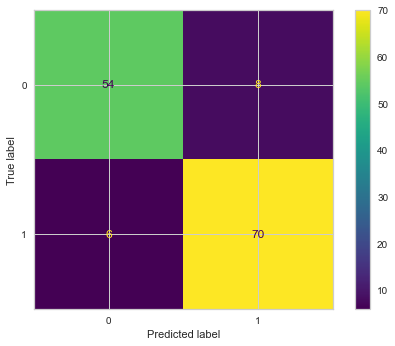

In [425]:
y_pred = SVM_grid_model.predict(X_test_scaled)
y_train_pred = SVM_grid_model.predict(X_train_scaled)

svm_grid_f1 = f1_score(y_test, y_pred)
svm_grid_acc = accuracy_score(y_test, y_pred)
svm_grid_recall = recall_score(y_test, y_pred)
svm_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(SVM_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

**GridSearchCV made a little contribution to True Positive predictions by increasing 69 to 70 while False Negative predictions stayed same.**

## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

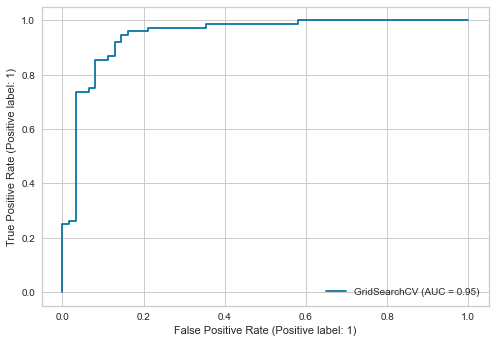

In [426]:
plot_roc_curve(SVM_grid_model, X_test_scaled, y_test);

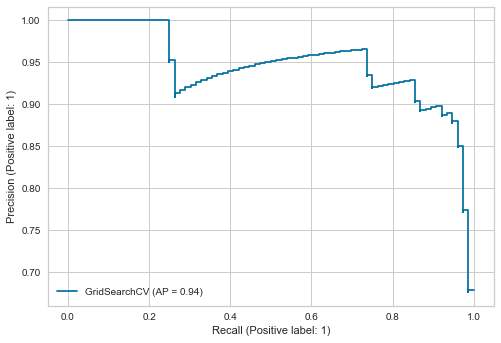

In [427]:
plot_precision_recall_curve(SVM_grid_model, X_test_scaled, y_test);

## THE COMPARISON OF MODELS

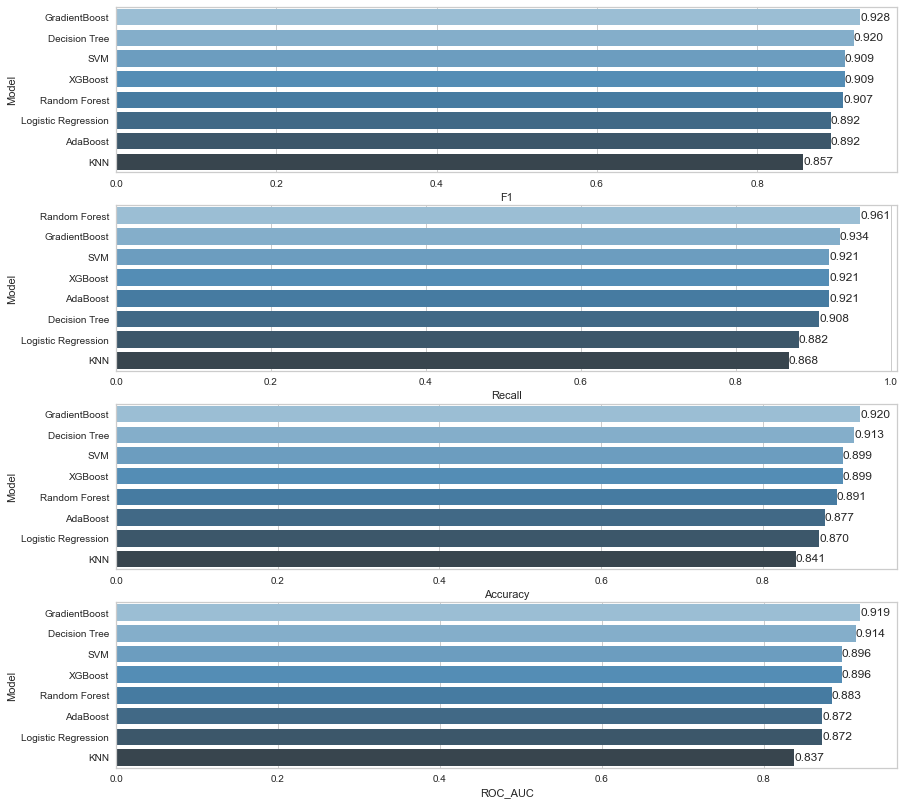

In [434]:
compare = pd.DataFrame({"Model": ["Logistic Regression", "SVM", "KNN", "Decision Tree", "Random Forest", "AdaBoost", "GradientBoost", "XGBoost"],
                        "F1": [log_f1, svm_grid_f1, knn_f1, dt_grid_f1, rf_grid_f1, ab_grid_f1, gb_f1, xgb_grid_f1],
                        "Recall": [log_recall, svm_grid_recall, knn_recall, dt_grid_recall, rf_grid_recall, ab_grid_recall, gb_recall, xgb_grid_recall],
                        "Accuracy": [log_acc, svm_grid_acc, knn_acc, dt_grid_acc, rf_grid_acc, ab_grid_acc, gb_acc, xgb_grid_acc],
                        "ROC_AUC": [log_auc, svm_grid_auc, knn_auc, dt_grid_auc, rf_grid_auc, ab_grid_auc, gb_auc, xgb_grid_auc]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,14))
plt.subplot(411)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(412)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(413)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(414)
compare = compare.sort_values(by="ROC_AUC", ascending=False)
ax=sns.barplot(x="ROC_AUC", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.show()